In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import plotly.express as px
import calendar
import pycountry as pycountry
# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from datetime import datetime
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../../../../OneDrive/Desktop/DA 2/finalProject_/european_wholesale_electricity_price_data_hourly.csv')
data.head()

Country ISO3 Code       Datetime (UTC)     Datetime (Local)  \
0  Austria       AUT  2015-01-01 00:00:00  2015-01-01 01:00:00   
1  Austria       AUT  2015-01-01 01:00:00  2015-01-01 02:00:00   
2  Austria       AUT  2015-01-01 02:00:00  2015-01-01 03:00:00   
3  Austria       AUT  2015-01-01 03:00:00  2015-01-01 04:00:00   
4  Austria       AUT  2015-01-01 04:00:00  2015-01-01 05:00:00   

   Price (EUR/MWhe)  
0             17.93  
1             15.17  
2             16.38  
3             17.38  
4             16.38

In [3]:
data_consumer_original = pd.read_csv('../../../../OneDrive/Desktop/DA 2/finalProject_/nrg_pc_204_linear.csv')
data_consumer_original.tail()

DATAFLOW        LAST UPDATE freq  product   consom unit  \
49975  ESTAT:NRG_PC_204(1.0)  27/10/22 23:00:00    S     6000  4161905  KWH   
49976  ESTAT:NRG_PC_204(1.0)  27/10/22 23:00:00    S     6000  4161905  KWH   
49977  ESTAT:NRG_PC_204(1.0)  27/10/22 23:00:00    S     6000  4161905  KWH   
49978  ESTAT:NRG_PC_204(1.0)  27/10/22 23:00:00    S     6000  4161905  KWH   
49979  ESTAT:NRG_PC_204(1.0)  27/10/22 23:00:00    S     6000  4161905  KWH   

         tax currency geo TIME_PERIOD  OBS_VALUE OBS_FLAG  
49975  X_VAT      PPS  UK     2018-S1     0.1325      NaN  
49976  X_VAT      PPS  UK     2018-S2     0.1452      NaN  
49977  X_VAT      PPS  UK     2019-S1     0.1453      NaN  
49978  X_VAT      PPS  UK     2019-S2     0.1553      NaN  
49979  X_VAT      PPS  UK     2020-S1     0.1554      NaN

In [4]:
data_consumer= data_consumer_original.copy()

In [5]:
data_wholesale= data.copy()

In [6]:
#convert column to date time
data_wholesale["Datetime (UTC)"] = pd.to_datetime(data_wholesale["Datetime (UTC)"])

In [7]:
#retrive just month and just year from date time
data_wholesale['Year'] = data_wholesale['Datetime (UTC)'].dt.strftime('%Y')
data_wholesale['Month'] = data_wholesale['Datetime (UTC)'].dt.strftime('%m')

In [8]:
#join month and year to make df more comperable to consumer one 
data_wholesale['Period'] = data_wholesale[['Year', 'Month']].agg('-'.join, axis=1)

In [9]:
data_wholesale = data_wholesale.drop(['Datetime (Local)', 'Datetime (UTC)'], axis = 1)

In [10]:
#start combining 
data_wholesale = data_wholesale.groupby(['Country', 'Period', 'Month', 'Year'], as_index=False)['Price (EUR/MWhe)'].mean()
data_wholesale.head()

Country   Period Month  Year  Price (EUR/MWhe)
0  Austria  2015-01    01  2015         31.679261
1  Austria  2015-02    02  2015         36.694182
2  Austria  2015-03    03  2015         31.297836
3  Austria  2015-04    04  2015         29.778597
4  Austria  2015-05    05  2015         25.330390

In [11]:
data_wholesale['Month'] = pd.to_numeric(data_wholesale['Month'])

In [12]:
# create a list of our conditions
conditions = [
    (data_wholesale['Month'] < 7),
    (data_wholesale['Month'] > 6)
    ]

# create a list of the values we want to assign for each condition
values = [1, 2]

# create a new column and use np.select to assign values to it using our lists as arguments
data_wholesale['period'] = np.select(conditions, values)

# display updated DataFrame
data_wholesale.head()

Country   Period  Month  Year  Price (EUR/MWhe)  period
0  Austria  2015-01      1  2015         31.679261       1
1  Austria  2015-02      2  2015         36.694182       1
2  Austria  2015-03      3  2015         31.297836       1
3  Austria  2015-04      4  2015         29.778597       1
4  Austria  2015-05      5  2015         25.330390       1

In [13]:
data_wholesale.describe()

Month  Price (EUR/MWhe)       period
count  2549.000000       2549.000000  2549.000000
mean      6.402903         69.504251     1.490388
std       3.415912         73.899872     0.500006
min       1.000000          1.877487     1.000000
25%       3.000000         34.534073     1.000000
50%       6.000000         43.922177     1.000000
75%       9.000000         59.431035     2.000000
max      12.000000        543.480417     2.000000

In [14]:
#data_total.describe()

In [15]:
#data_for_chart1.describe()

In [16]:
#columns to drop:DATAFLOW, LAST UPDATE, freq, product, 
data_consumer = data_consumer.drop(['DATAFLOW', 'LAST UPDATE', 'freq', 'product', 'OBS_FLAG'], axis = 1)

In [17]:
list_alpha_2 = [i.alpha_2 for i in list(pycountry.countries)]
list_alpha_3 = [i.alpha_3 for i in list(pycountry.countries)]    
list_alpha_4 = [i.alpha_3 for i in list(pycountry.countries)]

def country_flag(df):
    if (len(df['geo'])==2 and df['geo'] in list_alpha_2):
        return pycountry.countries.get(alpha_2=df['geo']).name
    elif (len(df['geo'])==3 and df['geo'] in list_alpha_3):
        return pycountry.countries.get(alpha_3=df['geo']).name
    else: return df['geo']

data_consumer['geo']=data_consumer.apply(country_flag, axis = 1)


In [18]:
data_consumer = data_consumer.replace(to_replace="EL", value = "Greece")
data_consumer = data_consumer.replace(to_replace="XK", value = "Kosova")
data_consumer = data_consumer.replace(to_replace="UK", value = "United Kingdom")


In [19]:
data_consumer = data_consumer[data_consumer["geo"].str.contains("EU27_2020") == False]

In [20]:
data_consumer = data_consumer[data_consumer["geo"].str.contains("EA") == False]

In [21]:
#consumer data- geo sorted, columns droped, has all tax, currency and all consumption bands
data_consumer['Consumer_price(EUR/MWhe)'] = data_consumer['OBS_VALUE'].multiply(other= 1000)

In [22]:
data_consumer = data_consumer.drop(['OBS_VALUE'], axis = 1)

In [23]:
data_consumer2= data_consumer.drop(data_consumer[data_consumer.tax == 'X_TAX'].index)

In [24]:
data_consumer3= data_consumer2.drop(data_consumer2[data_consumer2.tax == 'X_VAT'].index)

In [25]:
data_consumer3 = data_consumer2[data_consumer2['currency'].str.contains('EUR') == True]

In [26]:
data_consumer3 = data_consumer3.drop(['currency', 'unit'], axis = 1)
#consumer_3 is going to be ITAX and paying in Euros 

In [27]:
#consumer 4 is median by consumption and is ITAX paying in euros
data_consumer4 = data_consumer3.groupby(['geo', 'TIME_PERIOD'], as_index=False)['Consumer_price(EUR/MWhe)'].median()
data_consumer4.head(10)

geo TIME_PERIOD  Consumer_price(EUR/MWhe)
0  Albania     2011-S1                    105.60
1  Albania     2011-S2                    106.05
2  Albania     2012-S1                    106.60
3  Albania     2012-S2                    107.00
4  Albania     2013-S1                    105.95
5  Albania     2013-S2                    105.80
6  Albania     2014-S1                    105.95
7  Albania     2014-S2                    106.35
8  Albania     2015-S1                     74.40
9  Albania     2015-S2                     75.10

In [28]:
data_consumer4['period'] = data_consumer4['TIME_PERIOD'].apply(lambda x: 1 if data_consumer4['TIME_PERIOD'].str.contains('S1').
                               any() else 2 )
#lambda function to get 1 or to 2 dipending on S1 or S2

In [29]:
data_consumer4['A'], data_consumer4['B'] = data_consumer4['TIME_PERIOD'].str.split('-', 1).str
    #spliting column TIME_PERIOD in to columns A and B based on where - is 

In [30]:
data_consumer4.head()

geo TIME_PERIOD  Consumer_price(EUR/MWhe)  period     A   B
0  Albania     2011-S1                    105.60       1  2011  S1
1  Albania     2011-S2                    106.05       1  2011  S2
2  Albania     2012-S1                    106.60       1  2012  S1
3  Albania     2012-S2                    107.00       1  2012  S2
4  Albania     2013-S1                    105.95       1  2013  S1

In [31]:
data_consumer4 = data_consumer4.rename(columns={"A":"Year", "geo":"Country"})

starting merge of consumer 4 and wholesale data

In [32]:
data_joint = data_wholesale.assign(Period = data_wholesale.Year.astype(str) + ' ' + \
  data_wholesale.Month.astype(str) )

In [33]:
data_consumer4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1102 entries, 0 to 1101
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Country                   1102 non-null   object 
 1   TIME_PERIOD               1102 non-null   object 
 2   Consumer_price(EUR/MWhe)  1102 non-null   float64
 3   period                    1102 non-null   int64  
 4   Year                      1102 non-null   object 
 5   B                         1102 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 51.8+ KB


In [34]:
data_consumer4['period']= data_consumer4['period'].astype(str)

In [35]:
data_consumer4['period'] = data_consumer4['B'].map(lambda x: x.lstrip('S'))

In [36]:
#data_consumer5 = data_consumer4.assign(Period = data_consumer4.Year.astype(str) + ' ' + data_consumer4.period.astype(str))
data_consumer5 = data_consumer4.assign(Period = data_consumer4.Year.astype(str) + ' ' + \
  data_consumer4.period.astype(str) )

In [37]:
data_total = pd.merge(data_joint, data_consumer5,  how='left', 
                  left_on=['Country','Year'], 
                  right_on = ['Country','Year'])

In [38]:
data_total['period_y'].value_counts()
#more period 1 values as ending on period 2 for all 27 countries 

1    2455
2    2191
Name: period_y, dtype: int64

In [39]:
data_total['period_x'] =data_total['period_x'].astype(str)

In [40]:
print (data_total['period_x'] == data_total['period_y'])

0        True
1       False
2        True
3       False
4        True
        ...  
4735    False
4736    False
4737    False
4738    False
4739    False
Length: 4740, dtype: bool


In [41]:
data_total = data_total[data_total['period_x'] == data_total['period_y']]

In [42]:
data_clean= data_total.drop(['Month', 'Year', 'period_x', 'TIME_PERIOD', 'period_y', 'B', 'Period_y'], axis = 1)

In [43]:
data_clean= data_clean.rename(columns={'Period_x':'Year-month', 'Price (EUR/MWhe)':'Wholesale_price (EUR/MWhe)'})

In [44]:
data_clean.head()

Country Year-month  Wholesale_price (EUR/MWhe)  Consumer_price(EUR/MWhe)
0  Austria     2015 1                   31.679261                    189.45
2  Austria     2015 2                   36.694182                    189.45
4  Austria     2015 3                   31.297836                    189.45
6  Austria     2015 4                   29.778597                    189.45
8  Austria     2015 5                   25.330390                    189.45

In [45]:
Spain = data_clean.groupby(['Country']).get_group('Spain')
fig = px.bar(Spain, x= 'Year-month', y="Wholesale_price (EUR/MWhe)",
            title = 'Wholesale price per month in Spain',
             color_discrete_sequence = ['green'])
fig.show()

In [46]:
fig = px.bar(Spain, x= 'Year-month', y="Consumer_price(EUR/MWhe)",
            title = 'Consumer energy price',
             color_discrete_sequence = ['green'])
fig.show()

In [47]:
Finland = data_clean.groupby(['Country']).get_group('Finland')

In [48]:
fig = px.bar(Finland, x= 'Year-month', y="Wholesale_price (EUR/MWhe)",
            title = 'Wholesale price per month in Finland',
             color_discrete_sequence = ['green'])
fig.show()

In [49]:
fig = px.bar(Finland, x= 'Year-month', y="Consumer_price(EUR/MWhe)",
            title = 'Consumer energy price',
             color_discrete_sequence = ['green'])
fig.show()

In [50]:
fig = px.box(data_clean,x="Country", y="Wholesale_price (EUR/MWhe)",
            color_discrete_sequence = ['green'])
fig.show()


In [51]:
fig = px.box(data_clean,x="Country", y="Consumer_price(EUR/MWhe)",
            color_discrete_sequence = ['green'])
fig.show()

In [52]:
#data_for_chart = data_clean.iloc[:, 0:3]
#data_for_chart.head(10)
data_for_chart1 = data_clean.groupby('Year-month').agg({'Wholesale_price (EUR/MWhe)':'mean', 
                                                       'Consumer_price(EUR/MWhe)': 'mean'})
data_for_chart1.head()


Wholesale_price (EUR/MWhe)  Consumer_price(EUR/MWhe)
Year-month                                                      
2015 1                       39.218003                172.333333
2015 10                      41.667156                171.935417
2015 11                      38.874619                171.935417
2015 12                      35.305435                171.935417
2015 2                       40.620946                172.333333

In [53]:
data_for_chart1 = data_for_chart1.reset_index()

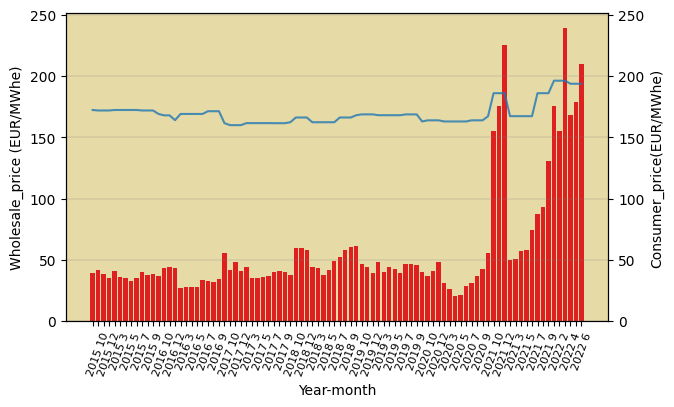

In [54]:
# now we plot!!
fig, ax1 = plt.subplots(figsize=(7,4)) # we create a figure that is going to contain subplots

ax2 = ax1.twinx() # we create a second twin axis that will share the x axis of the first!


ax1.get_shared_y_axes().join(ax1, ax2) #making values on x and y axis to match

#bar plot for wholesale prices 
sns.barplot(data_for_chart1['Year-month'] ,x= data_for_chart1['Year-month'], 
            y=data_for_chart1['Wholesale_price (EUR/MWhe)'], 
            color="red", ax=ax1)

# and now we plot the consumer prices assigning ax2 as axis
sns.lineplot(data_for_chart1['Year-month'] , x= data_for_chart1['Year-month'], 
             y=data_for_chart1['Consumer_price(EUR/MWhe)'], ax = ax2, alpha=0.8) 
# alpha goes from 0 to 1 and changes the transparency, useful in overlaping graphs

# finally, we add some elements to make it nicer
#ax1.legend(loc='center left', bbox_to_anchor=(1.2, 0.5)) # note that we just add a legend for ax1
ax1.set_facecolor('xkcd:beige') # more colors in: https://xkcd.com/color/rgb/
ax1.grid(False)
ax2.grid(color='grey', linestyle='-', linewidth=0.2) # we create a grid for ax2
ax1.tick_params(axis='x', rotation=70, labelsize = 8)
ax2.tick_params(axis='x', rotation=70, labelsize = 8)
for label in ax1.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)


In [55]:
violin_data=data_clean.copy()

In [56]:
data_clean['Year-month'].value_counts(normalize = True)*100

2018 10    1.148936
2019 9     1.148936
2020 1     1.148936
2019 12    1.148936
2019 11    1.148936
             ...   
2016 5     1.021277
2016 7     1.021277
2016 8     1.021277
2016 9     1.021277
2015 1     1.021277
Name: Year-month, Length: 90, dtype: float64

In [57]:
violin_data['year'] = data_clean['Year-month'].str[:4]
violin_data


Country Year-month  Wholesale_price (EUR/MWhe)  \
0     Austria     2015 1                   31.679261   
2     Austria     2015 2                   36.694182   
4     Austria     2015 3                   31.297836   
6     Austria     2015 4                   29.778597   
8     Austria     2015 5                   25.330390   
...       ...        ...                         ...   
4637   Sweden     2022 2                   65.226890   
4638   Sweden     2022 3                  108.385255   
4639   Sweden     2022 4                   83.556764   
4640   Sweden     2022 5                   95.359395   
4641   Sweden     2022 6                  114.827917   

      Consumer_price(EUR/MWhe)  year  
0                       189.45  2015  
2                       189.45  2015  
4                       189.45  2015  
6                       189.45  2015  
8                       189.45  2015  
...                        ...   ...  
4637                    232.65  2022  
4638                    232.65  2022  
4639                    232.65  2022  
4640                    232.65  2022  
4641                    232.65  2022  

[2350 rows x 5 columns]

In [58]:
violin_data['year'] = data_clean['Year-month'].str[:4]
violin_data


Country Year-month  Wholesale_price (EUR/MWhe)  \
0     Austria     2015 1                   31.679261   
2     Austria     2015 2                   36.694182   
4     Austria     2015 3                   31.297836   
6     Austria     2015 4                   29.778597   
8     Austria     2015 5                   25.330390   
...       ...        ...                         ...   
4637   Sweden     2022 2                   65.226890   
4638   Sweden     2022 3                  108.385255   
4639   Sweden     2022 4                   83.556764   
4640   Sweden     2022 5                   95.359395   
4641   Sweden     2022 6                  114.827917   

      Consumer_price(EUR/MWhe)  year  
0                       189.45  2015  
2                       189.45  2015  
4                       189.45  2015  
6                       189.45  2015  
8                       189.45  2015  
...                        ...   ...  
4637                    232.65  2022  
4638                    232.65  2022  
4639                    232.65  2022  
4640                    232.65  2022  
4641                    232.65  2022  

[2350 rows x 5 columns]

In [59]:
vilolin_data = violin_data.groupby('year').agg({'Wholesale_price (EUR/MWhe)':'mean', 
                                                       'Consumer_price(EUR/MWhe)': 'mean'})
violin_data.head(5)

violin_data = violin_data.drop(['Year-month'], axis = 1)

violin_data['year']= violin_data['year'].astype(int)


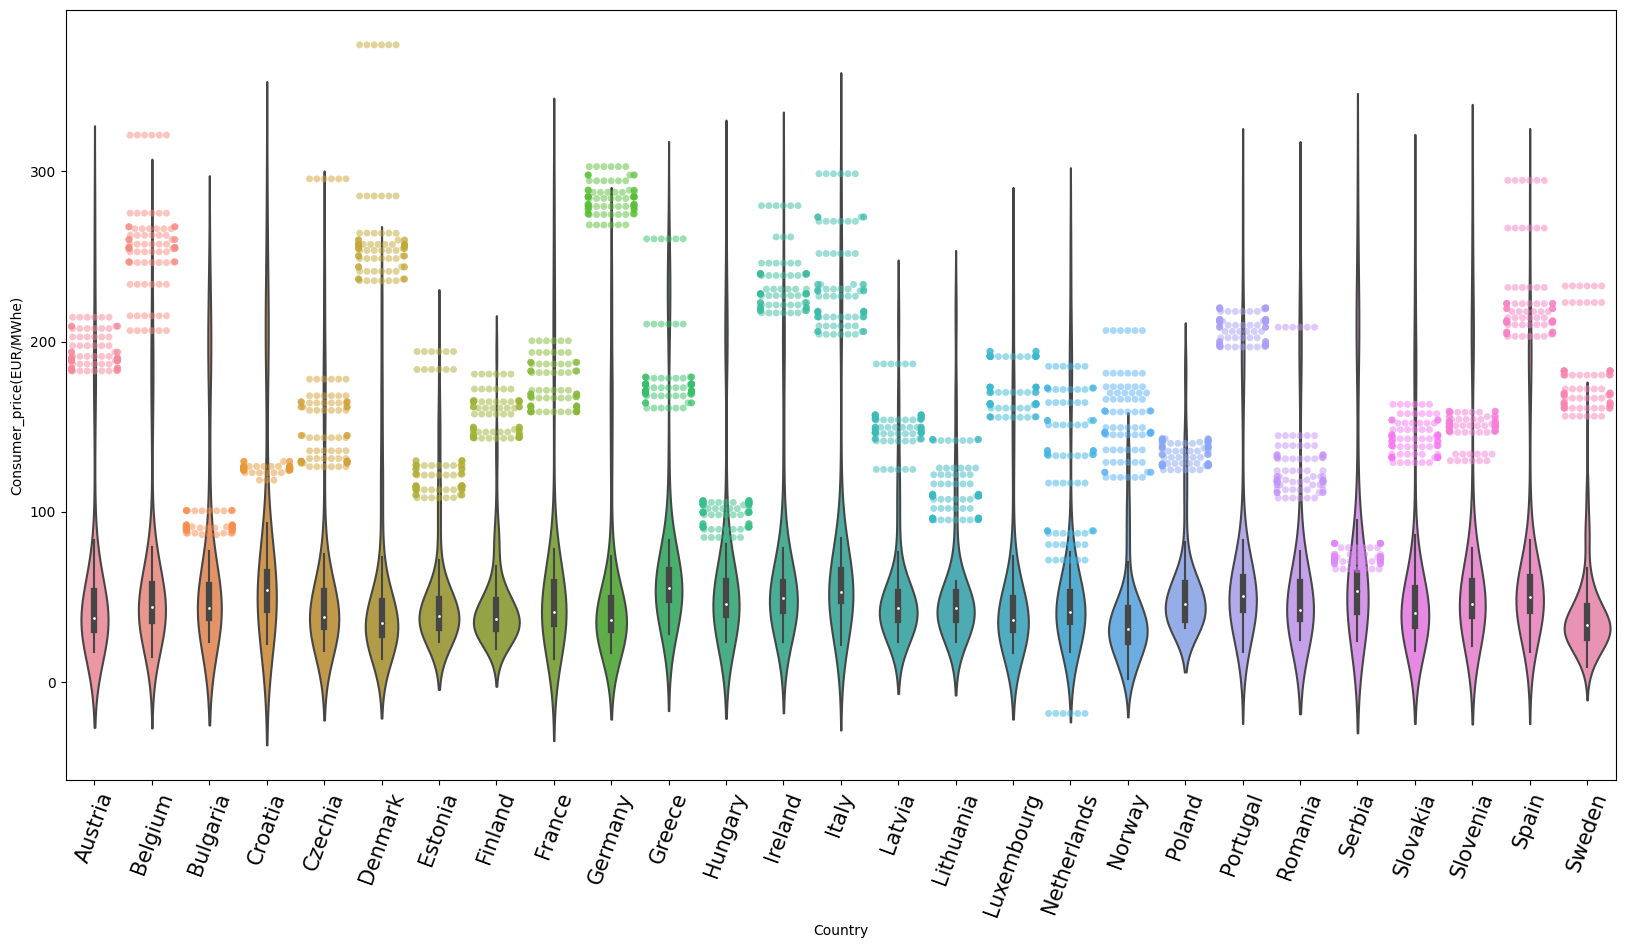

In [60]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 10))

# Draw a violinplot with a narrower bandwidth than the default
sns.violinplot(data=data_clean, x= 'Country',
               y='Wholesale_price (EUR/MWhe)')
sns.swarmplot(x='Country', y='Consumer_price(EUR/MWhe)', data=data_clean, 
              alpha=0.5) # transparency of the points
sns.color_palette("dark:salmon_r", as_cmap=True)
# Finalize the figure
ax.tick_params(axis='x', rotation=70, labelsize = 15)


In [61]:
data_consumer.head()

consom unit    tax currency      geo TIME_PERIOD  Consumer_price(EUR/MWhe)
0  4161901  KWH  I_TAX      EUR  Albania     2011-S1                     115.2
1  4161901  KWH  I_TAX      EUR  Albania     2011-S2                     115.7
2  4161901  KWH  I_TAX      EUR  Albania     2012-S1                     116.3
3  4161901  KWH  I_TAX      EUR  Albania     2012-S2                     116.7
4  4161901  KWH  I_TAX      EUR  Albania     2013-S1                     115.6

In [62]:
data_tax = data_consumer.copy()

In [63]:
data_tax1 = data_tax[data_tax['currency'].str.contains('EUR') == True]

In [64]:
data_taxPPS = data_tax[data_tax['currency'].str.contains('PPS') == True]

In [65]:
Italy = data_tax1[data_tax1['geo'].str.contains('Italy') == True]

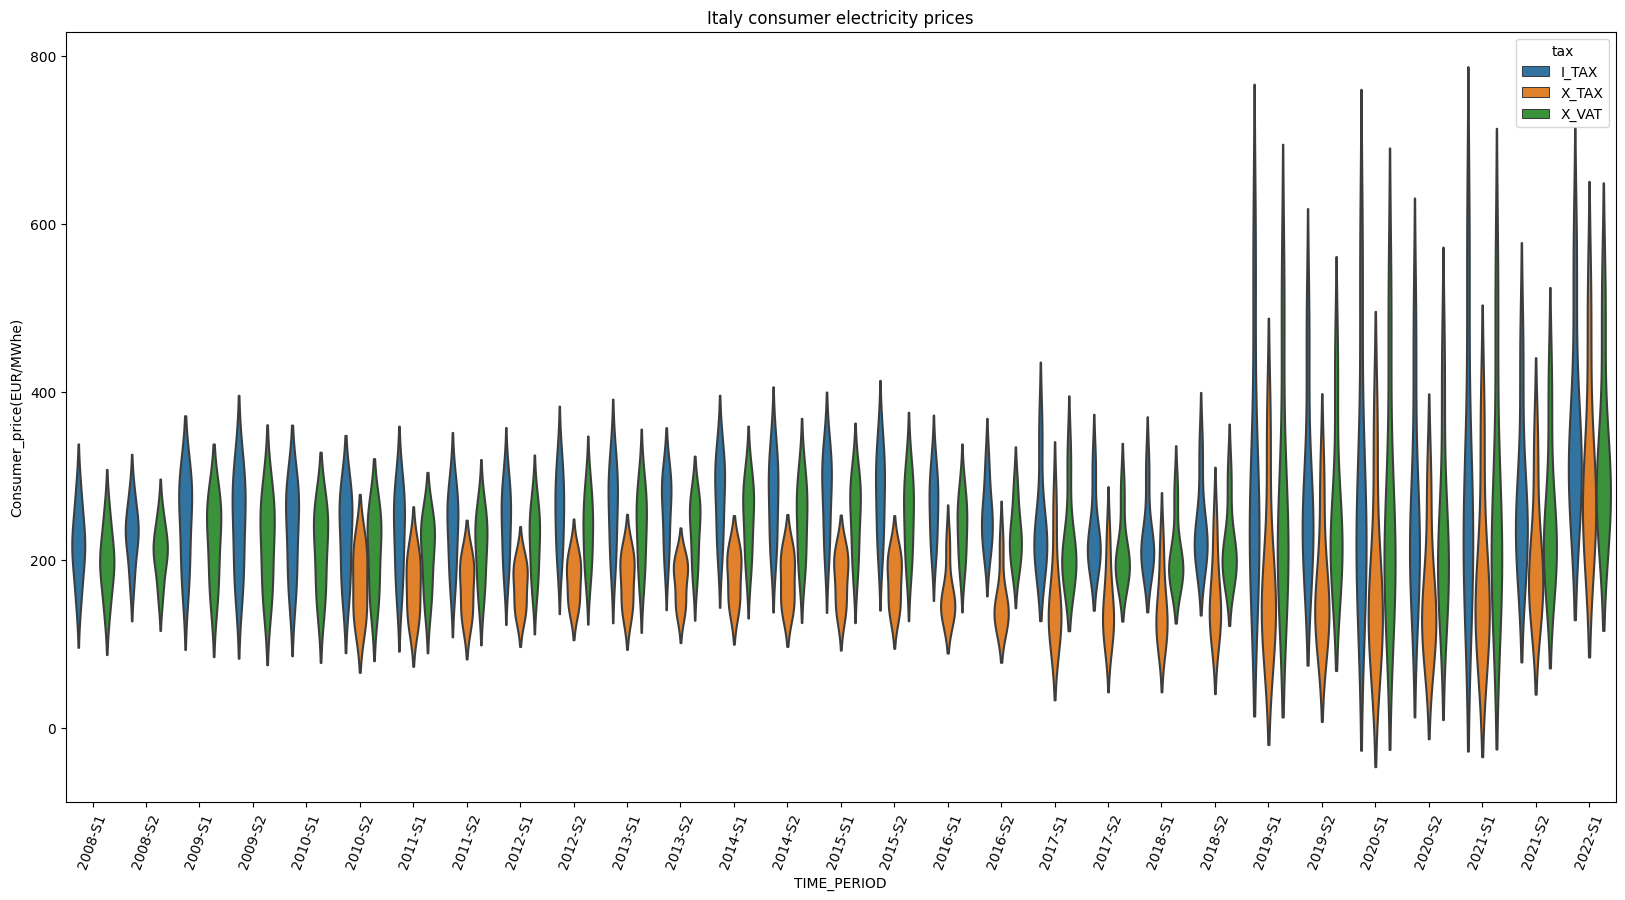

In [66]:
f, ax = plt.subplots(figsize=(20, 10))
# Create plot
sns.violinplot(x='TIME_PERIOD',y='Consumer_price(EUR/MWhe)', hue ="tax", data=Italy, inner=None)
#sns.swarmplot(x='TIME_PERIOD', y='Price', data=EU27_2020, color='black') # transparency of the points

plt.title('Italy consumer electricity prices')
ax.tick_params(axis='x', rotation=70, labelsize = 10)


In [67]:
Bulgaria = data_tax1[data_tax1['geo'].str.contains('Bulgaria') == True]

In [68]:
EU27_2020 = data_tax1[data_tax1['geo'].str.contains('EU27_2020') == True]

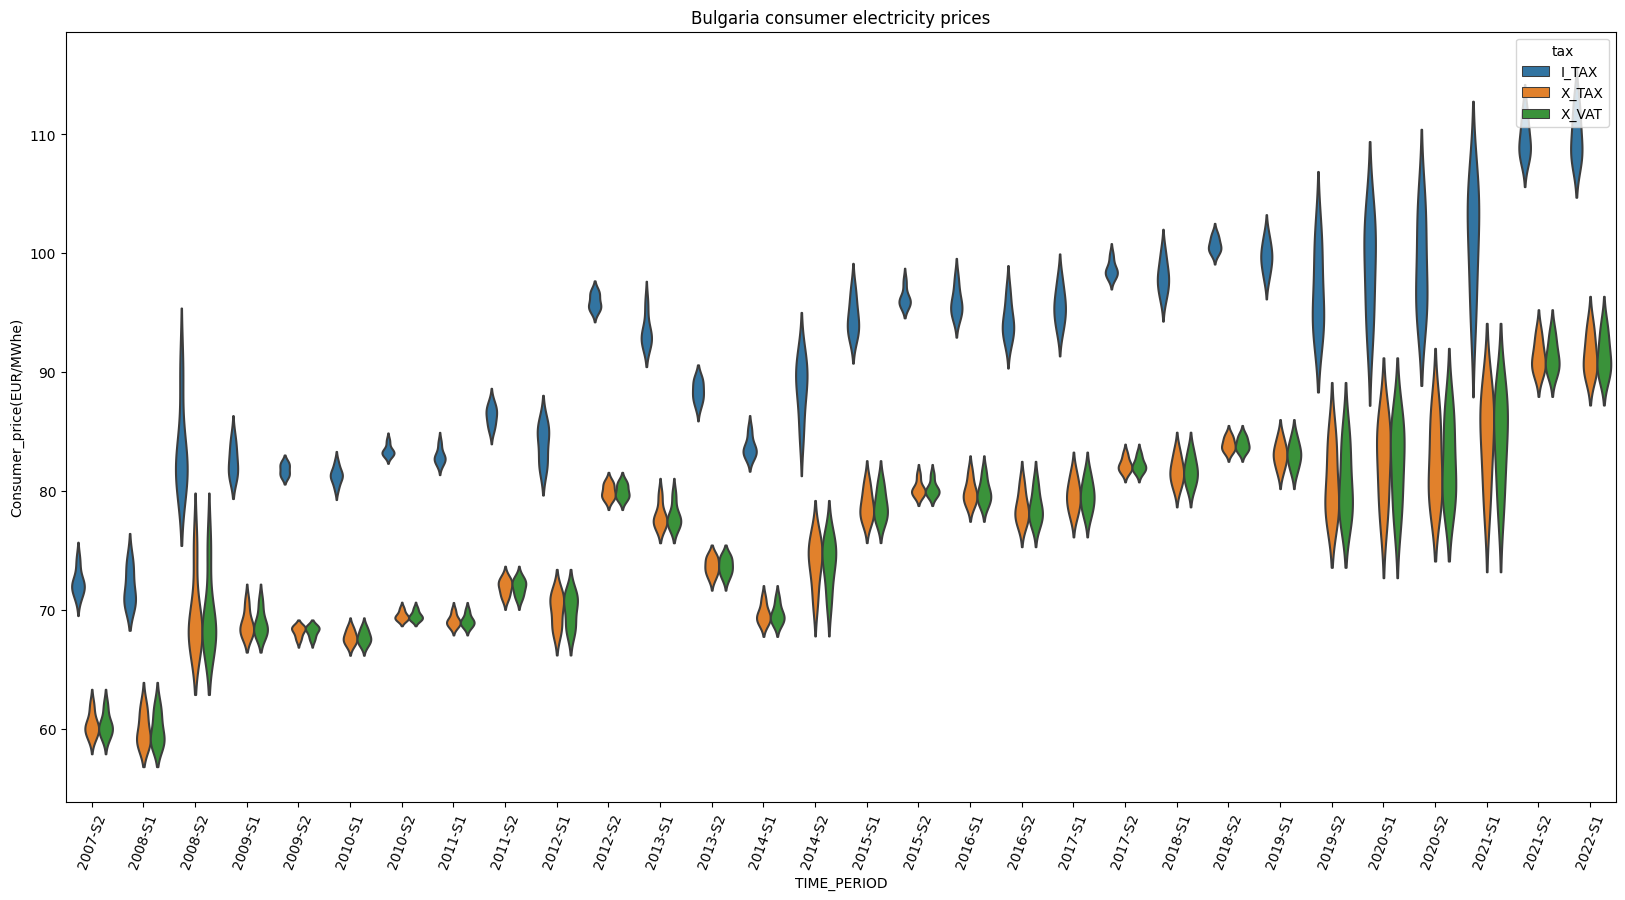

In [69]:

f, ax = plt.subplots(figsize=(20, 10))
# Create plot
sns.violinplot(x='TIME_PERIOD',y='Consumer_price(EUR/MWhe)', hue ="tax", data=Bulgaria, inner=None)
#sns.swarmplot(x='TIME_PERIOD', y='Price', data=EU27_2020, color='black') # transparency of the points

plt.title('Bulgaria consumer electricity prices')
ax.tick_params(axis='x', rotation=70, labelsize = 10)


In [70]:
Spain = data_tax1[data_tax1['geo'].str.contains('Spain') == True]
SpainPPS = data_taxPPS[data_taxPPS['geo'].str.contains('Spain') == True]

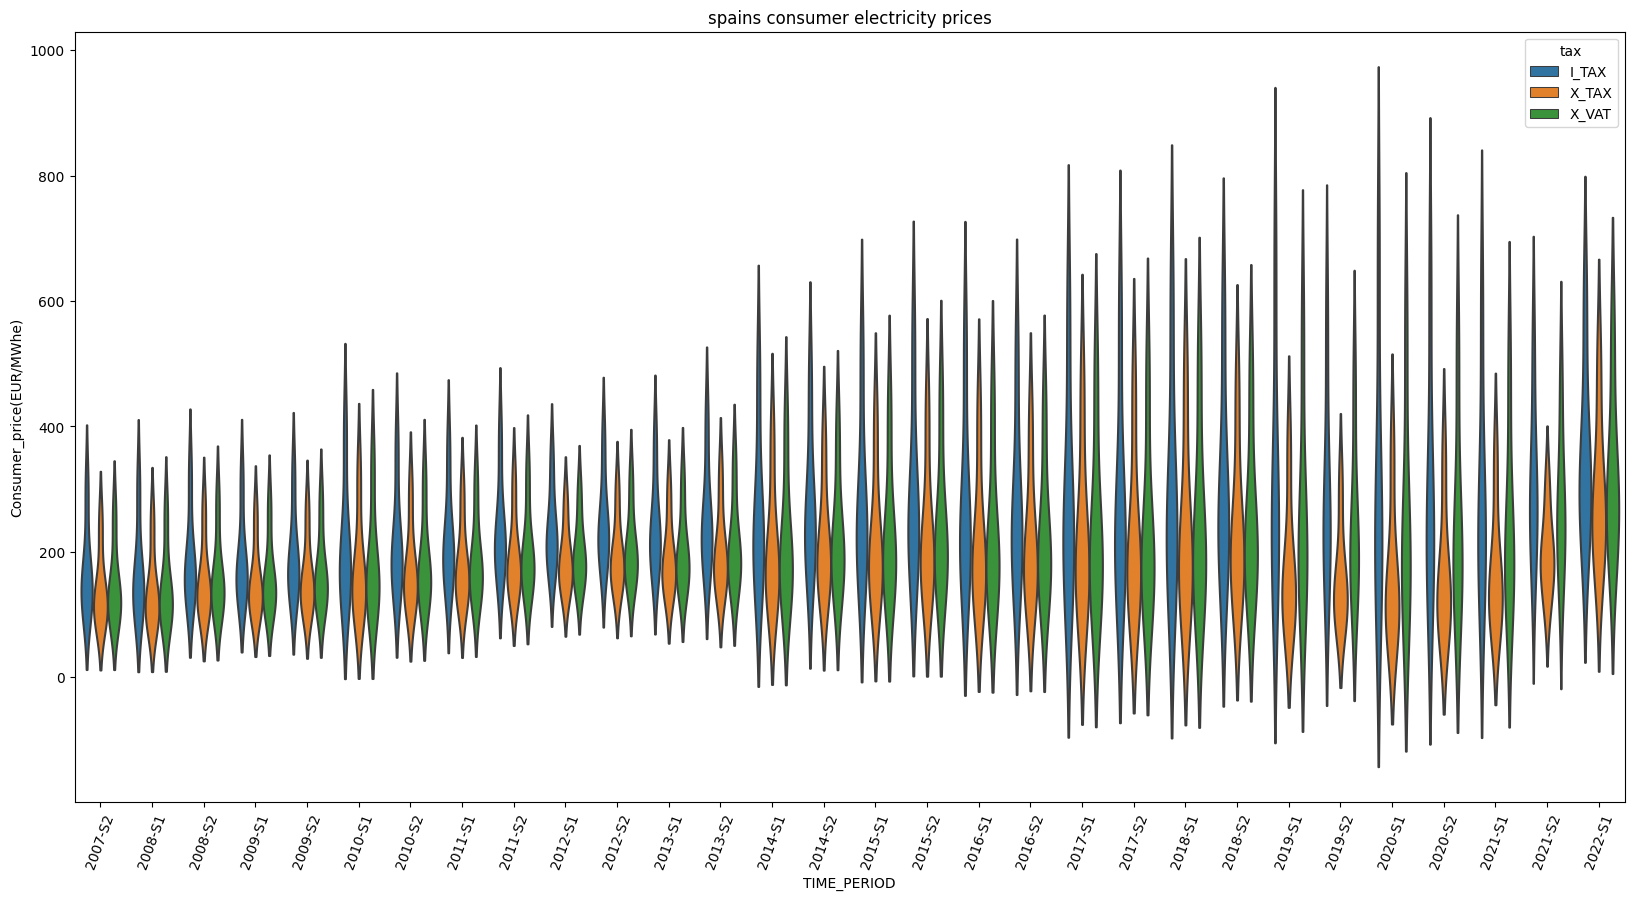

In [71]:

f, ax = plt.subplots(figsize=(20, 10))
# Create plot
sns.violinplot(x='TIME_PERIOD',y='Consumer_price(EUR/MWhe)', hue ="tax", data=Spain, inner=None)
#sns.swarmplot(x='TIME_PERIOD', y='Price', data=SpainPPS, color='black') # transparency of the points
 
plt.title('spains consumer electricity prices')
ax.tick_params(axis='x', rotation=70, labelsize = 10)

In [72]:
Hungary = data_tax1[data_tax1['geo'].str.contains('Hungary') == True]

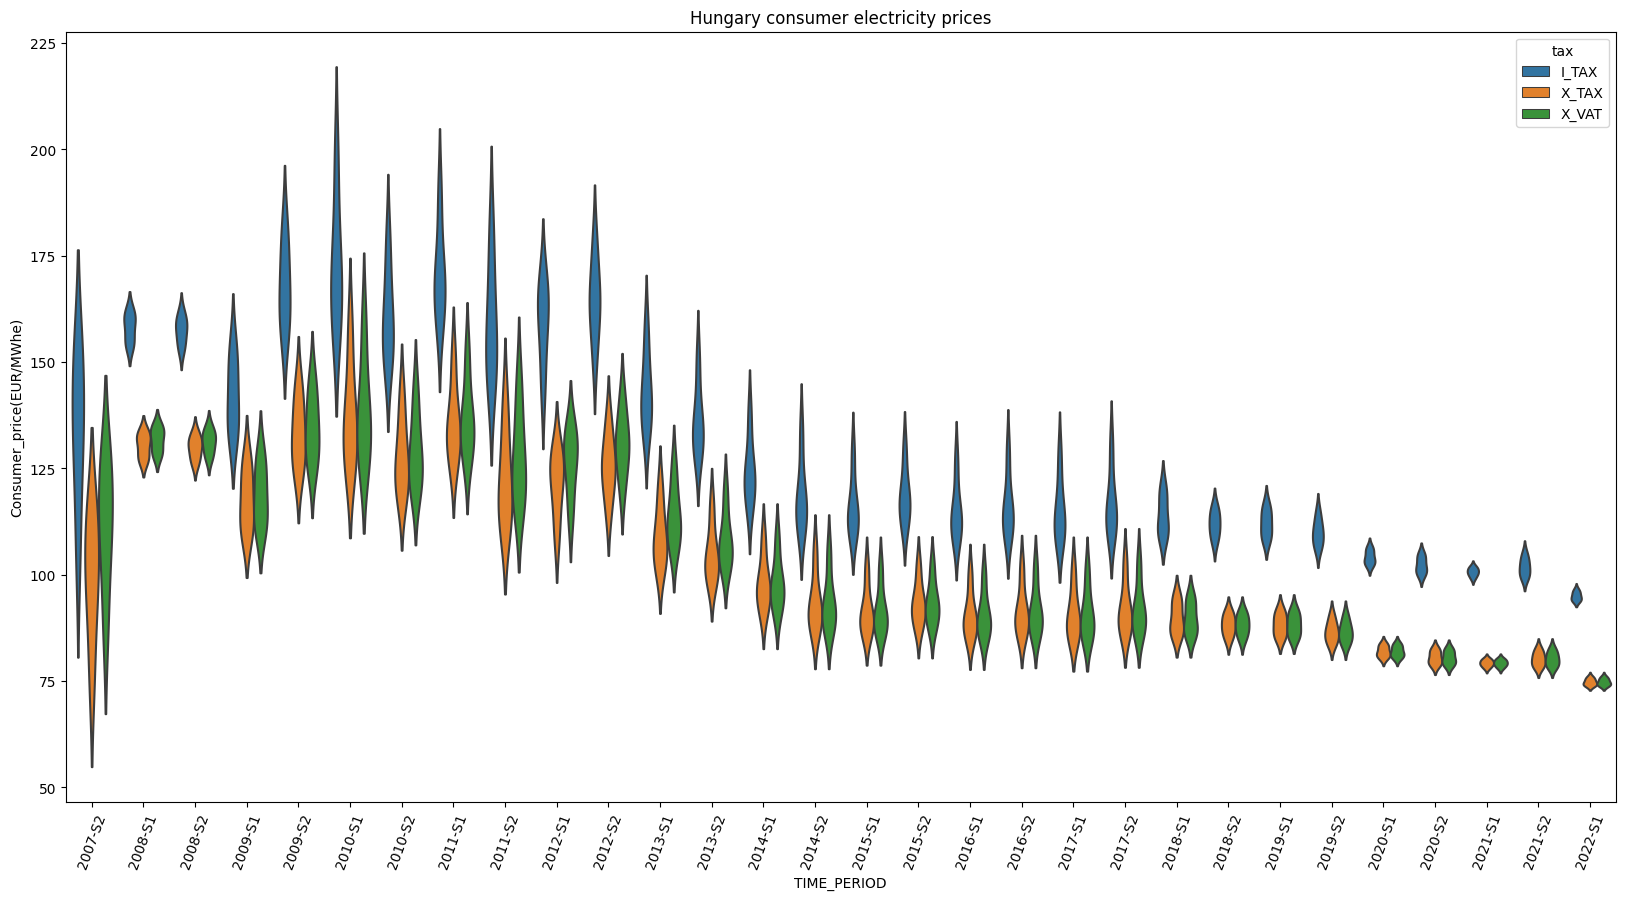

In [73]:

f, ax = plt.subplots(figsize=(20, 10))
# Create plot
sns.violinplot(x='TIME_PERIOD',y='Consumer_price(EUR/MWhe)', hue ="tax", data=Hungary, inner=None)
 
plt.title('Hungary consumer electricity prices')
ax.tick_params(axis='x', rotation=70, labelsize = 10)


In [74]:
Latvia = data_tax1[data_tax1['geo'].str.contains('Latvia') == True]

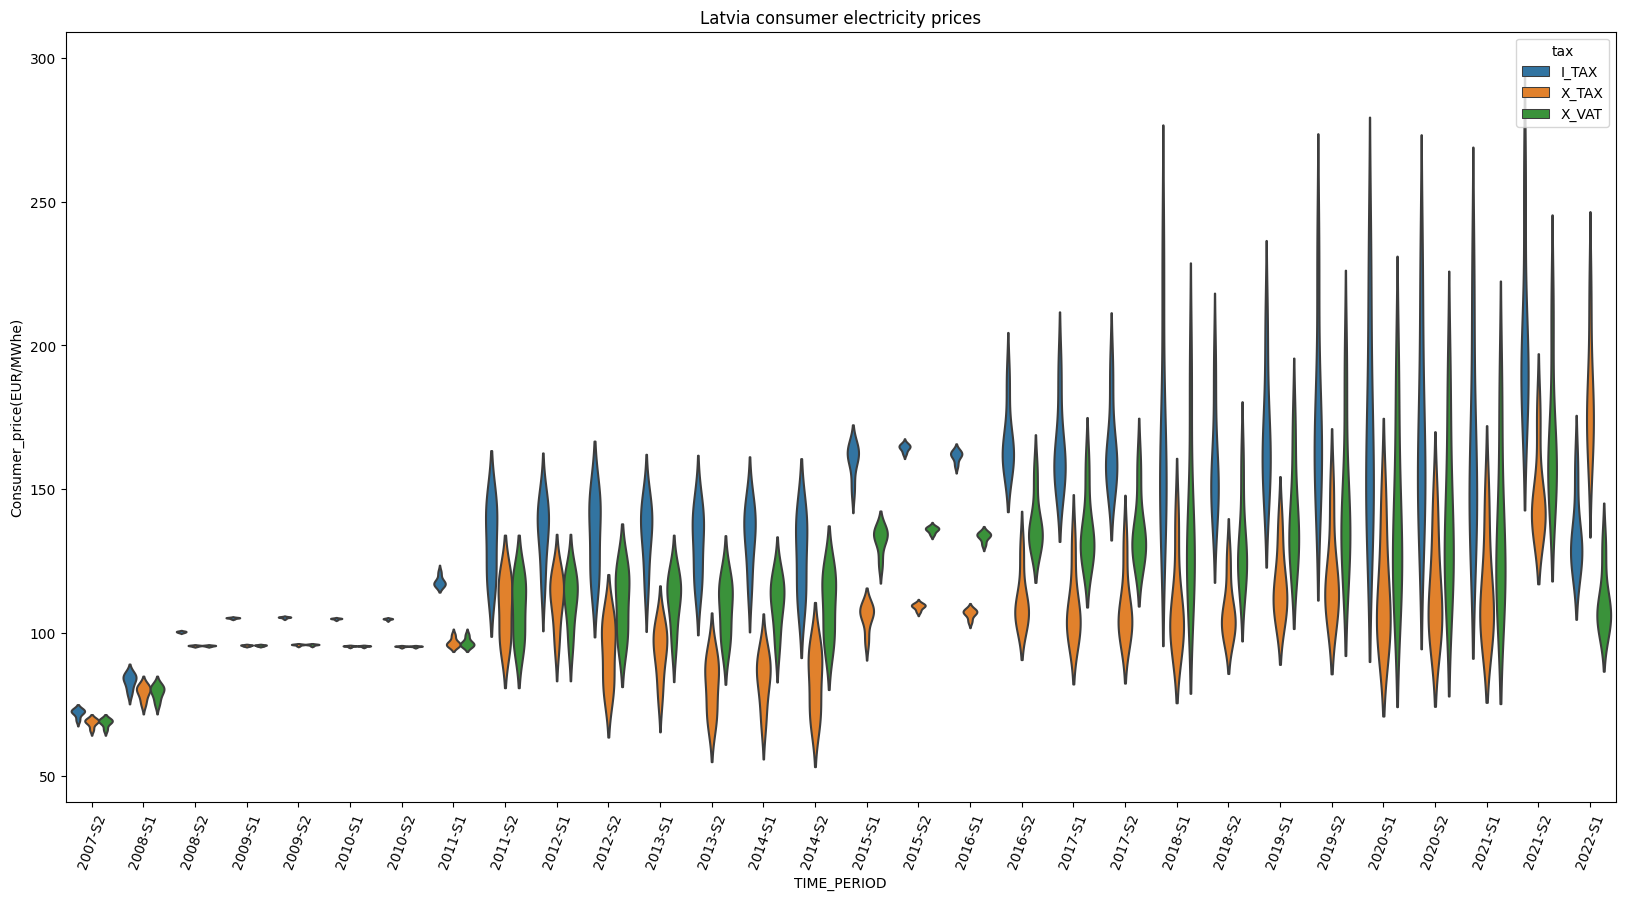

In [75]:

f, ax = plt.subplots(figsize=(20, 10))
# Create plot
sns.violinplot(x='TIME_PERIOD',y='Consumer_price(EUR/MWhe)', hue ="tax", data=Latvia, inner=None)
#sns.swarmplot(x='TIME_PERIOD', y='Price', data=EU27_2020, color='black') 
#sns.swarmplot(x='TIME_PERIOD', y='Price', data=LatviaPPS, color='black') # transparency of the points
 
plt.title('Latvia consumer electricity prices')
ax.tick_params(axis='x', rotation=70, labelsize = 10)

In [76]:
#to do k means i will turn one price coumn in 3 columns, one kind of tax level in each and see is i can group them by this. 
#I will only be looking at tax band diffrences and can we predict consumer price from 
#whih group country will be.
#we are using data tax - consumer copy paying in euros

In [77]:
data_tax2= data_tax1.drop(['consom'], axis = 1)

In [78]:
data_tax2 = data_tax2.groupby(['geo', 'TIME_PERIOD', 'tax'], as_index=False)['Consumer_price(EUR/MWhe)'].median()

In [79]:
data_Itax = data_tax2[data_tax2['tax'].str.contains('I_TAX') == True]
data_Itax= data_Itax.rename(columns={'Consumer_price(EUR/MWhe)':'Price_ITAX'})
data_Itax = data_Itax.drop(['tax'], axis = 1)
data_Itax

geo TIME_PERIOD  Price_ITAX
0            Albania     2011-S1       115.2
3            Albania     2011-S2       115.7
6            Albania     2012-S1       116.3
9            Albania     2012-S2       116.7
12           Albania     2013-S1       115.6
...              ...         ...         ...
3286  United Kingdom     2018-S1       188.7
3289  United Kingdom     2018-S2       202.4
3292  United Kingdom     2019-S1       212.2
3295  United Kingdom     2019-S2       221.0
3298  United Kingdom     2020-S1       220.3

[1102 rows x 3 columns]

In [80]:
data_Xtax = data_tax2[data_tax2['tax'].str.contains('X_TAX') == True]
data_Xtax= data_Xtax.rename(columns={'Consumer_price(EUR/MWhe)':'Price_XTAX'})
data_Xtax = data_Xtax.drop(['tax'], axis = 1)
data_Xtax

geo TIME_PERIOD  Price_XTAX
1            Albania     2011-S1        96.0
4            Albania     2011-S2        96.4
7            Albania     2012-S1        96.9
10           Albania     2012-S2        97.3
13           Albania     2013-S1        96.3
...              ...         ...         ...
3287  United Kingdom     2018-S1       134.7
3290  United Kingdom     2018-S2       140.1
3293  United Kingdom     2019-S1       145.0
3296  United Kingdom     2019-S2       151.2
3299  United Kingdom     2020-S1       153.2

[1097 rows x 3 columns]

In [81]:
data_Xvat = data_tax2[data_tax2['tax'].str.contains('X_VAT') == True]
data_Xvat= data_Xvat.rename(columns={'Consumer_price(EUR/MWhe)':'Price_XVAT'})
data_Xvat = data_Xvat.drop(['tax'], axis = 1)
data_Xvat

geo TIME_PERIOD  Price_XVAT
2            Albania     2011-S1        96.0
5            Albania     2011-S2        96.4
8            Albania     2012-S1        96.9
11           Albania     2012-S2        97.3
14           Albania     2013-S1        96.3
...              ...         ...         ...
3288  United Kingdom     2018-S1       179.7
3291  United Kingdom     2018-S2       192.7
3294  United Kingdom     2019-S1       202.1
3297  United Kingdom     2019-S2       210.6
3300  United Kingdom     2020-S1       209.9

[1102 rows x 3 columns]

In [82]:
data_K = pd.merge(data_Itax, data_Xtax,  how='outer', 
                  on=['geo','TIME_PERIOD'])

In [83]:
data_K = pd.merge(data_K, data_Xvat,  how='outer', 
                  on=['geo','TIME_PERIOD'])

In [84]:
data_K = data_K.drop_duplicates()

In [85]:
data_K['geo'].value_counts()

Netherlands               31
Croatia                   31
Czechia                   31
Luxembourg                31
Sweden                    31
Germany                   31
Latvia                    30
Spain                     30
Portugal                  30
Romania                   30
Malta                     30
Lithuania                 30
Slovakia                  30
Austria                   30
Slovenia                  30
Ireland                   30
Greece                    30
Hungary                   30
Norway                    30
France                    30
Finland                   30
Estonia                   30
Denmark                   30
Cyprus                    30
Bulgaria                  30
Turkey                    30
Belgium                   30
Poland                    30
Italy                     29
United Kingdom            26
Bosnia and Herzegovina    25
Montenegro                23
Albania                   22
Iceland                   21
North Macedoni

In [86]:
data_K = data_K.drop([500, 501, 502, 503, 504])

In [87]:
data_K['geo'] = data_K[['geo' ,'TIME_PERIOD']].agg('-'.join, axis=1)
#data_wholesale['Period'] = data_wholesale[['Year', 'Month']].agg('-'.join, axis=1)

In [88]:
data_K = data_K.set_index("geo")

In [89]:
data_K = data_K.drop(['Netherlands-2022-S1'])

In [90]:
data_K = data_K.drop(['TIME_PERIOD'], axis=1)

In [91]:
data_K
count_nan = data_K['Price_XVAT'].isnull().sum()

print('Number of NaN values present: ' + str(count_nan))
#we got theses because of merge

Number of NaN values present: 0


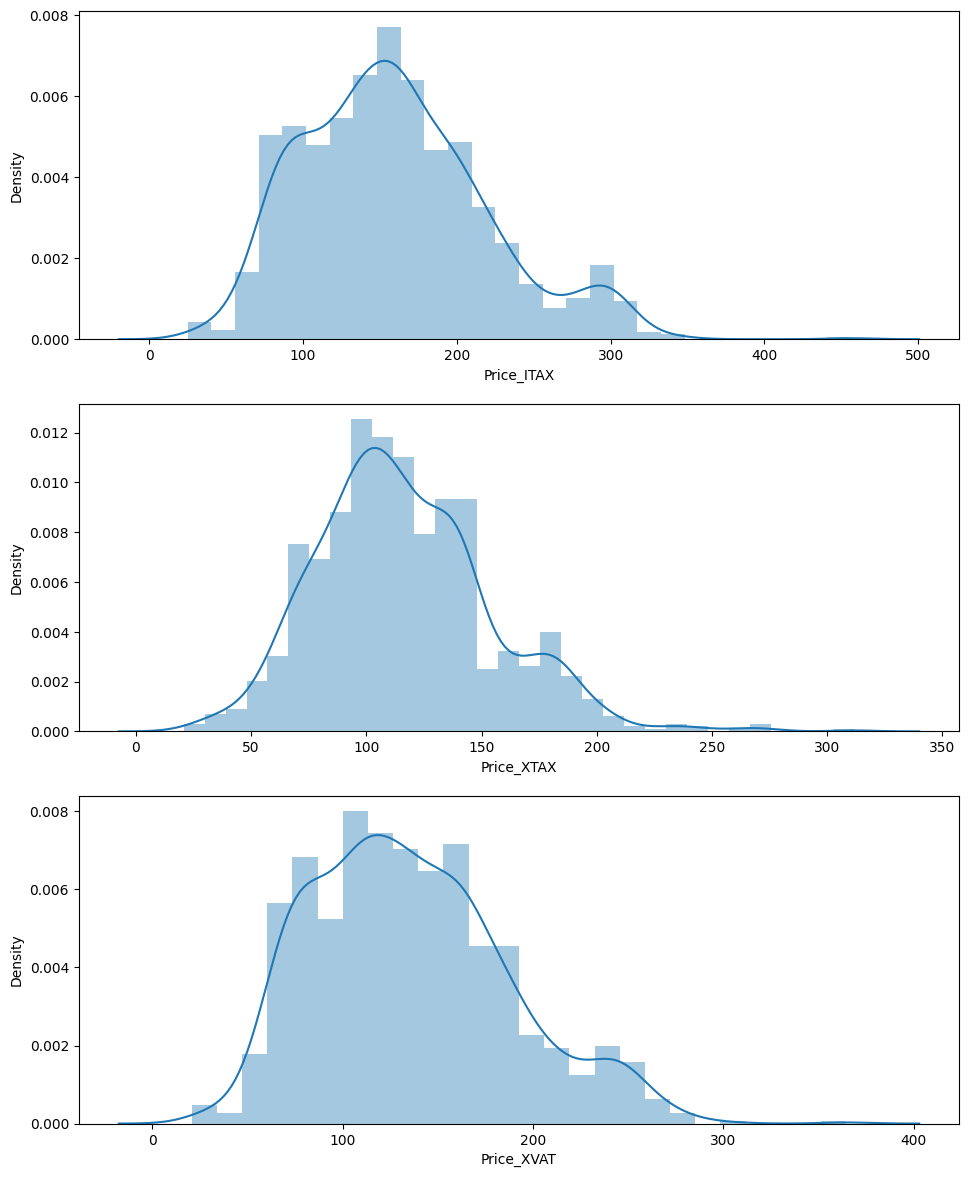

In [92]:
# plot the distribution of RFM values
plt.subplots(figsize=(10, 12))

plt.subplot(3, 1, 1);
sns.distplot(data_K.Price_ITAX, label = 'Price_ITAX')

plt.subplot(3, 1, 2); 
sns.distplot(data_K.Price_XTAX, label = 'Price_XTAX')

plt.subplot(3, 1, 3); 
sns.distplot(data_K.Price_XVAT, label = 'Price_XVAT')

plt.style.use('fivethirtyeight')
plt.tight_layout()
plt.show();

In [93]:
data_K = data_K[['Price_XTAX', 'Price_XVAT', 'Price_ITAX']].apply(np.log1p, 
                                                               axis = 1).round(3)

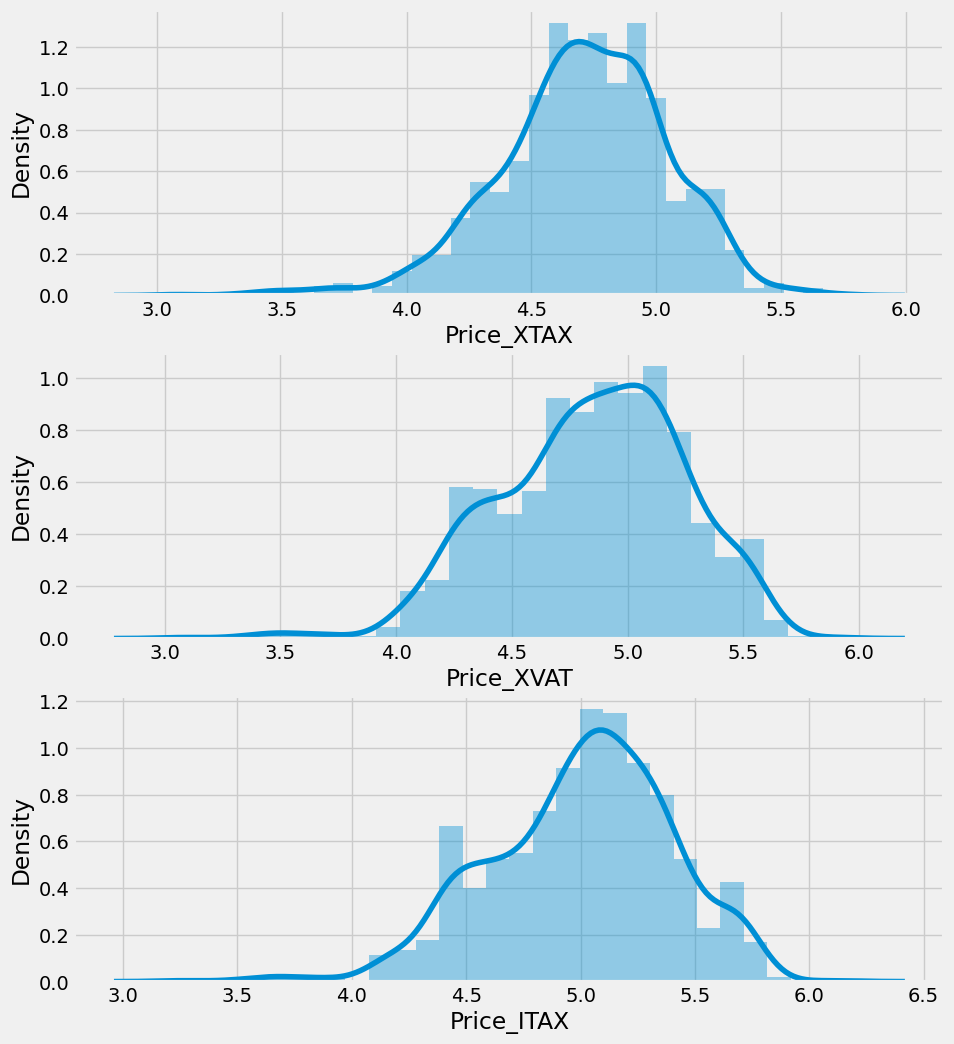

In [94]:
# plot the distribution of RFM values
plt.subplots(figsize=(10, 12))
plt.subplot(3, 1, 1)
sns.distplot(data_K.Price_XTAX, label = 'Price_XTAX')

plt.subplot(3, 1, 2)
sns.distplot(data_K.Price_XVAT, label = 'Price_XVAT')

plt.subplot(3, 1, 3)
sns.distplot(data_K.Price_ITAX, label = 'Price_ITAX')

#plt.style.use('black')
#plt.tight_layout()
plt.show()

In [95]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#Store it separately for clustering
data_K_scaled = scaler.fit_transform(data_K)

In [96]:
data_K_scaled = pd.DataFrame(data_K_scaled)
data_K_scaled.columns = data_K.columns


In [97]:
from sklearn.cluster import KMeans
inertia = []

#First : Get the Best KMeans 
ks = range(1,20)

for i in ks:
    kmeans = KMeans(n_clusters= i, random_state=42)
    kmeans.fit(data_K_scaled)
    inertia.append(kmeans.inertia_)

    #inertia_ is the formula used to segregate the data points 
    # into clusters

In [98]:
inertia

[3288.0,
 1266.0869475320726,
 752.4323178551789,
 552.1678168404433,
 424.07484870479,
 350.50221113184233,
 284.92335901842415,
 238.68399320327083,
 207.9868755474145,
 181.59429456805012,
 162.77840932201758,
 148.92978037252914,
 136.2836073815469,
 124.25908885836158,
 113.67563585152509,
 106.36722563149978,
 100.66773990183995,
 91.26732716098957,
 86.09808519722995]

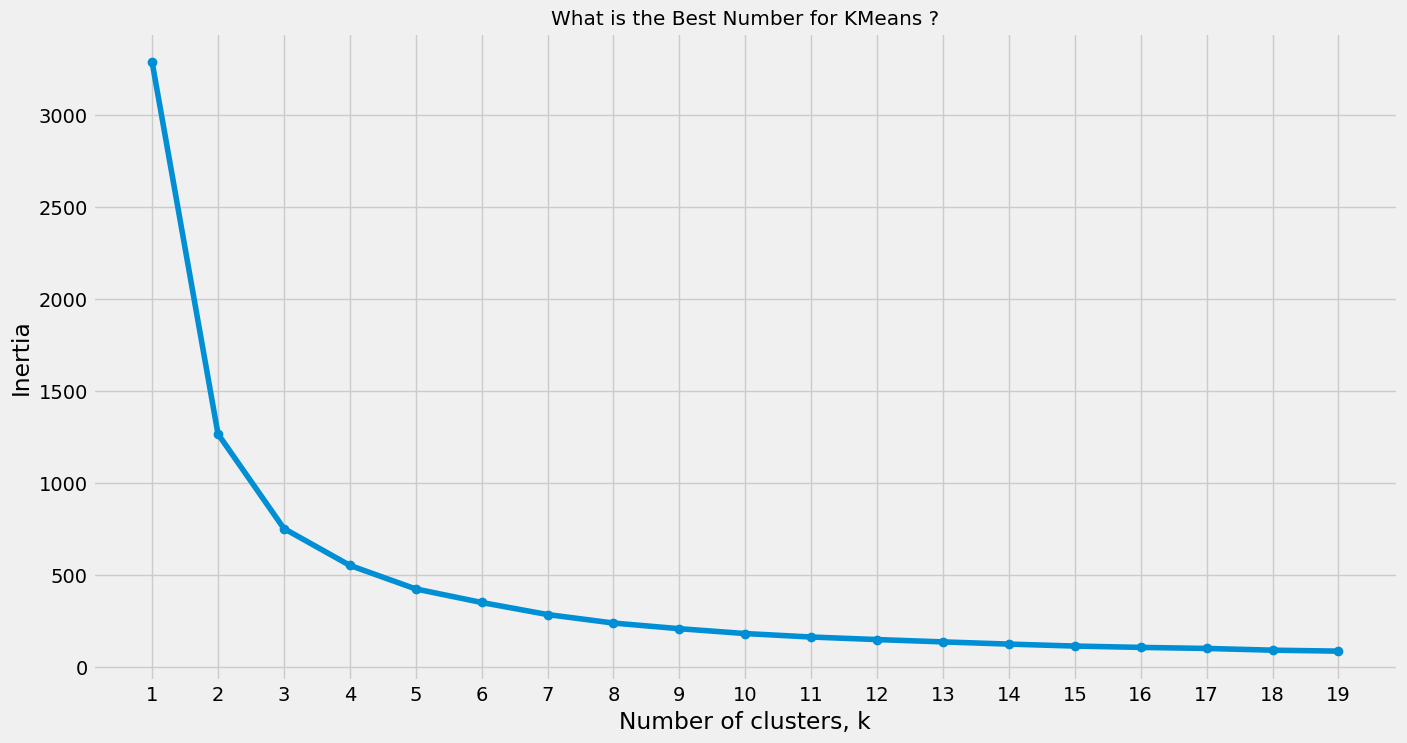

In [99]:
# Plot ks vs inertias
f, ax = plt.subplots(figsize=(15, 8))
plt.plot(ks, inertia, '-o')

plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.style.use('ggplot')
plt.title('What is the Best Number for KMeans ?')
plt.show()

In [100]:
from kneed import KneeLocator
kl = KneeLocator(ks, inertia,curve="convex", direction="decreasing")
kl

In [101]:
print('The elbow point of your model is:', kl.elbow)

The elbow point of your model is: 4


In [102]:
# Final model with k=4
kmeans = KMeans(n_clusters=4, 
                max_iter=400, random_state=42)

#
kmeans.fit(data_K_scaled)

KMeans(max_iter=400, n_clusters=4, random_state=42)

In [103]:
data_K_scaled['cluster_id'] = kmeans.labels_
data_K_scaled.head()

Price_XTAX  Price_XVAT  Price_ITAX  cluster_id
0   -0.397508   -0.671256   -0.627991           0
1   -0.385711   -0.661237   -0.615392           0
2   -0.370966   -0.648714   -0.602794           0
3   -0.359169   -0.638695   -0.595235           0
4   -0.388660   -0.663742   -0.617912           0

In [104]:
data_K['cluster_id'] = kmeans.labels_
data_K.head()

Price_XTAX  Price_XVAT  Price_ITAX  cluster_id
geo                                                            
Albania-2011-S1       4.575       4.575       4.755           0
Albania-2011-S2       4.579       4.579       4.760           0
Albania-2012-S1       4.584       4.584       4.765           0
Albania-2012-S2       4.588       4.588       4.768           0
Albania-2013-S1       4.578       4.578       4.759           0

In [105]:
data_K_scaled['cluster_id'].value_counts()

1    398
0    314
3    222
2    162
Name: cluster_id, dtype: int64

In [106]:
def plot_clusters(df_sc, var1, var2, colors, cluster_id='cluster_id'):

 
    total_clusters = df_sc.cluster_id.nunique()     
    fig = px.scatter(df_sc, x = var1, y = var2, color = cluster_id, 
                     color_continuous_scale=colors)
    fig.update_layout(coloraxis_showscale=False)
    fig.show()

In [107]:
colors_clusters = ['Coral', 'DarkCyan', 
                   'Gold','Lightgreen']

In [108]:
plot_clusters(data_K, 'Price_XTAX', 'Price_XVAT',colors_clusters)

In [109]:
#making the plot in 3D, colour could be considered 4th dimension
import plotly.graph_objs as go
import plotly
#Make Plotly figure
color_discrete_map = {0: 'Coral', 1: 'DarkCyan', 2: 'Gold', 3: 'Lightgreen'}
fig1 = go.Scatter3d(x=data_K_scaled["Price_XTAX"],
                    y=data_K_scaled["Price_XVAT"],
                    z=data_K_scaled["Price_ITAX"],
                    marker=dict(color=data_K_scaled["cluster_id"],
                                opacity=0.9,
                                reversescale=True,
                                colorscale=colors_clusters),
                    line=dict(width=0.02),
                    mode='markers')

#Make Plot.ly Layout
mylayout = go.Layout(scene=dict(xaxis=dict(title="Price_XTAX"),
                                yaxis=dict(title="Price_XVAT"),
                                zaxis=dict(title="Price_ITAX")),)


      
             
#Plot and save html
plotly.offline.plot({"data": [fig1],
                     "layout": mylayout},
                     auto_open=True,
                     filename=("4DPlot.html"))



'4DPlot.html'

In [110]:
color_discrete_map = ('Coral', 'DarkCyan','Gold','Lightgreen')

In [111]:
data_K_scaled.index= data_K.index

In [112]:
data_cluster = data_K_scaled.groupby(['cluster_id'], as_index=False)

In [113]:
data_K = data_K.reset_index(level=0)

In [114]:
data_K[['geo', 'date']] = data_K['geo'].str.split('-', 1, expand=True)

In [115]:
data_OK = data_K.groupby(['geo'], as_index=False)['cluster_id'].mean()

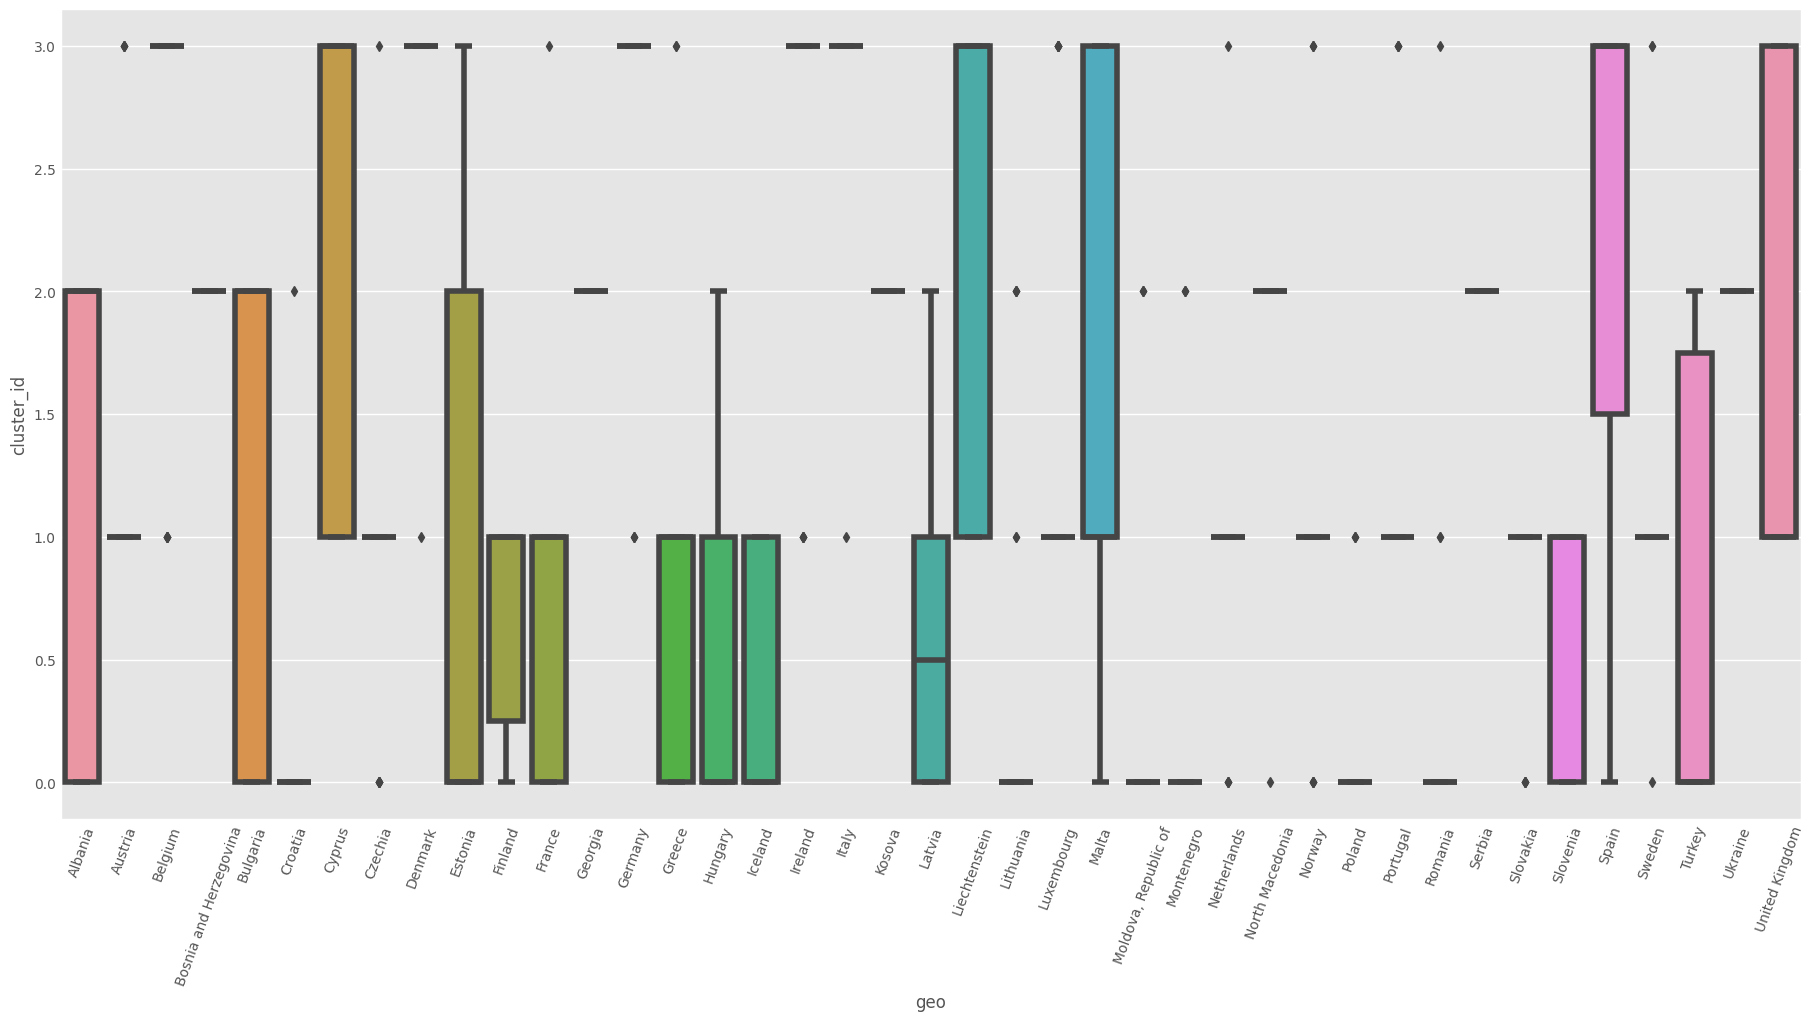

In [116]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 10))

# Draw a violinplot with a narrower bandwidth than the default
sns.boxplot(x='geo', y='cluster_id', data=data_K) # transparency of the points

# Finalize the figure
ax.tick_params(axis='x', rotation=70, labelsize = 10)

In [117]:
data_K.head(5)

geo  Price_XTAX  Price_XVAT  Price_ITAX  cluster_id     date
0  Albania       4.575       4.575       4.755           0  2011-S1
1  Albania       4.579       4.579       4.760           0  2011-S2
2  Albania       4.584       4.584       4.765           0  2012-S1
3  Albania       4.588       4.588       4.768           0  2012-S2
4  Albania       4.578       4.578       4.759           0  2013-S1

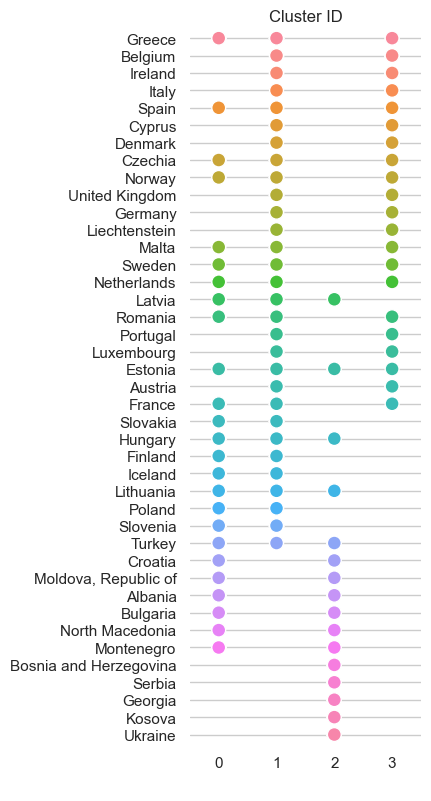

In [118]:
sns.set_theme(style="whitegrid")


# Make the PairGrid
g = sns.PairGrid(data_K.sort_values("Price_XTAX", ascending=False),
                 x_vars=data_K.columns[4], y_vars=["geo"],
                 height=8, aspect=.4)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h", jitter=False, linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(-0.5, 3.5), xlabel=" ", ylabel="")

# Use semantically meaningful titles for the columns
titles = ["Cluster ID"]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
    
    

sns.despine(left=True, bottom=True)

In [119]:
data_K=data_K.sort_values(by=['date'])

In [120]:
 colors_clusters = ['Coral', 'DarkCyan', 'Gold','Lightgreen']

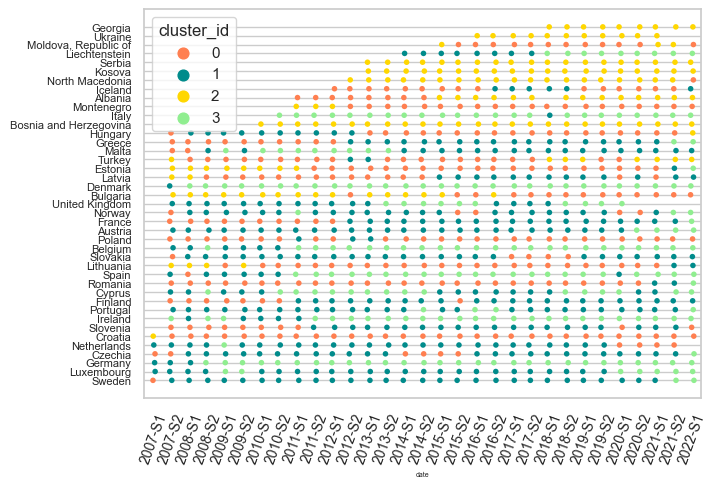

In [121]:
g=sns.stripplot(data=data_K, x="date", y="geo", hue="cluster_id", 
                  hue_order=None, jitter=True, dodge=False, 
                  palette=colors_clusters, size=4, edgecolor='gray', linewidth=0, 
                  ax=None)

g.set_xlabel("date",fontsize=5)
g.set_ylabel("",fontsize=5)
g.tick_params(axis='x', rotation=70, labelsize = 10)
g.tick_params(axis='y', rotation=0, labelsize = 8)

In [122]:
fig = px.choropleth(data_K,  # Input Pandas DataFrame
                    locations="geo", locationmode="country names", # DataFrame column with locations
                    color="cluster_id", 
                    animation_frame = 'date',
                    color_continuous_scale= ['Coral', 'DarkCyan', 'Gold','Lightgreen'],
                    range_color=(0,3)) # DataFrame column with color values

fig.show()  # Output the plot to the screen

In [123]:
#lets look at 6 countries, 2 of each group(excluding class2 as we dont have EU countries in that)
data_test = data_consumer.loc[data_consumer['geo'].isin(['Croatia', 'Spain', 'Czechia', 'Estonia',
                                                         'Germany', 'Bulgaria', 'Sweden'])]


In [124]:
#using Euros to make for comapring 
data_test = data_test.loc[data_consumer['currency'].isin(['EUR'])]

In [125]:
#need to drop 2007S1 as we have data only for Germany and Czechia for that period
data_test = data_test[data_test["TIME_PERIOD"].str.contains("2007-S1") == False]

In [126]:
data_test['currency'].value_counts()

EUR    3150
Name: currency, dtype: int64

In [127]:
data_test.describe()

consom  Consumer_price(EUR/MWhe)
count  3.150000e+03               3150.000000
mean   4.161903e+06                159.016635
std    1.414438e+00                 88.114326
min    4.161901e+06                 51.500000
25%    4.161902e+06                 95.700000
50%    4.161903e+06                130.350000
75%    4.161904e+06                196.700000
max    4.161905e+06                669.800000

In [128]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3150 entries, 103 to 47654
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   consom                    3150 non-null   int64  
 1   unit                      3150 non-null   object 
 2   tax                       3150 non-null   object 
 3   currency                  3150 non-null   object 
 4   geo                       3150 non-null   object 
 5   TIME_PERIOD               3150 non-null   object 
 6   Consumer_price(EUR/MWhe)  3150 non-null   float64
dtypes: float64(1), int64(1), object(5)
memory usage: 196.9+ KB


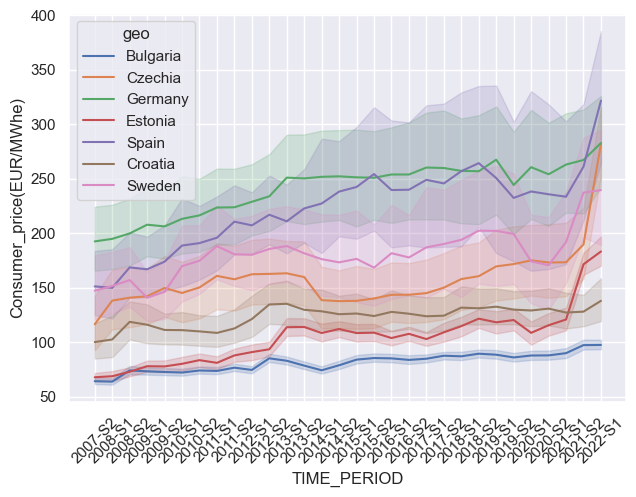

In [129]:

sns.set_theme(style="darkgrid")

sns.lineplot(x="TIME_PERIOD", y="Consumer_price(EUR/MWhe)",
             hue="geo", 
             #style="consom",
             data=data_test)
plt.xticks=plt.xticks(rotation=45)


In [130]:
data_test['TIME_PERIOD'] = data_test['TIME_PERIOD'].replace(('-S' ,' '), regex=True)


In [131]:
data_test['period'] = data_test['TIME_PERIOD'].apply(lambda x: 1 if data_consumer4['TIME_PERIOD'].str.contains('S1').
                               any() else 2 )
#lambda function to get 1 or to 2 dipending on S1 or S2

In [132]:
data_test['A'], data_test['B'] = data_test['TIME_PERIOD'].str.split('-', 1).str

In [133]:
data_test['period'] = data_test['B'].map(lambda x: x.lstrip('S'))

In [134]:
#data_consumer5 = data_consumer4.assign(Period = data_consumer4.Year.astype(str) + ' ' + data_consumer4.period.astype(str))
data_test = data_test.assign(Period = data_test.A.astype(str) + '.' + \
  data_test.period.astype(str) )

In [135]:
data_test['Period'] = data_test['Period'].astype(float)

In [136]:
data_test['tax'].value_counts()

I_TAX    1050
X_TAX    1050
X_VAT    1050
Name: tax, dtype: int64

In [137]:
#seperating in clases, this data only have euros, all tax values, all consumption values

In [138]:
data_test_class0 = data_test.loc[data_consumer['geo'].isin(['Estonia', 'Croatia'])]

In [139]:
data_test_class1 = data_test.loc[data_consumer['geo'].isin(['Czechia', 'Sweden'])]

In [140]:
data_test_class2 = data_test.loc[data_consumer['geo'].isin(['Bulgaria'])]

In [141]:
data_test_class3 = data_test.loc[data_consumer['geo'].isin(['Spain', 'Germany'])]

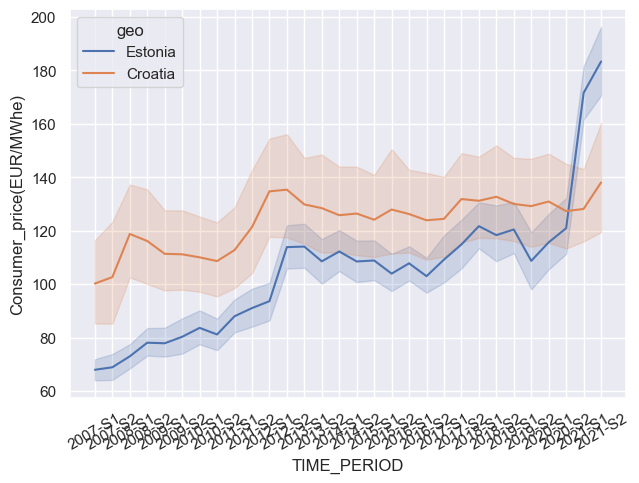

In [142]:

sns.set_theme(style="darkgrid")

fig = sns.lineplot(x="TIME_PERIOD", y="Consumer_price(EUR/MWhe)",
             hue="geo", 
             #style="consom",
             data=data_test_class0)
#fig.set_xticks(rotation=45)
fig.xticks = fig.set_xticklabels(g.get_xticklabels(), rotation=30)

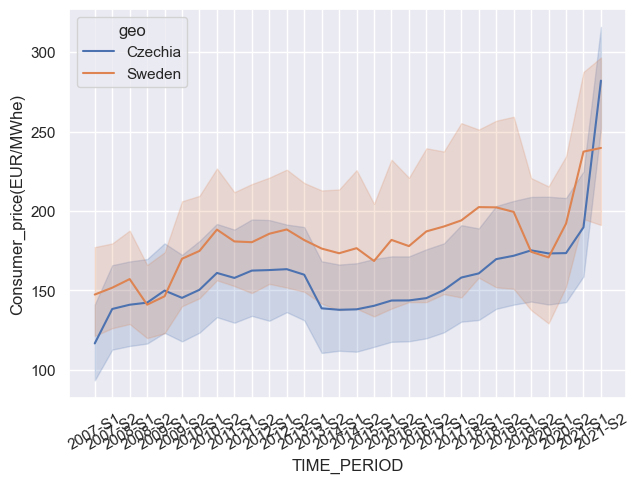

In [143]:

sns.set_theme(style="darkgrid")

fig = sns.lineplot(x="TIME_PERIOD", y="Consumer_price(EUR/MWhe)",
             hue="geo", 
             #style="consom",
             data=data_test_class1)
fig.xticks = fig.set_xticklabels(g.get_xticklabels(), rotation=30)

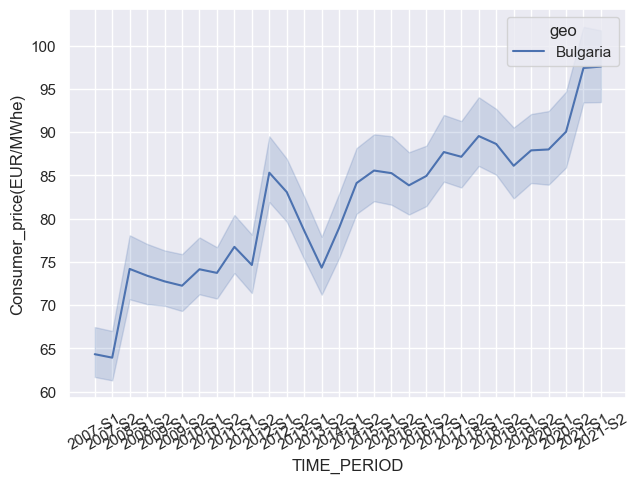

In [144]:

sns.set_theme(style="darkgrid")

fig = sns.lineplot(x="TIME_PERIOD", y="Consumer_price(EUR/MWhe)",
             hue="geo", 
             #style="consom",
             data=data_test_class2)
fig.xticks = fig.set_xticklabels(g.get_xticklabels(), rotation=30)

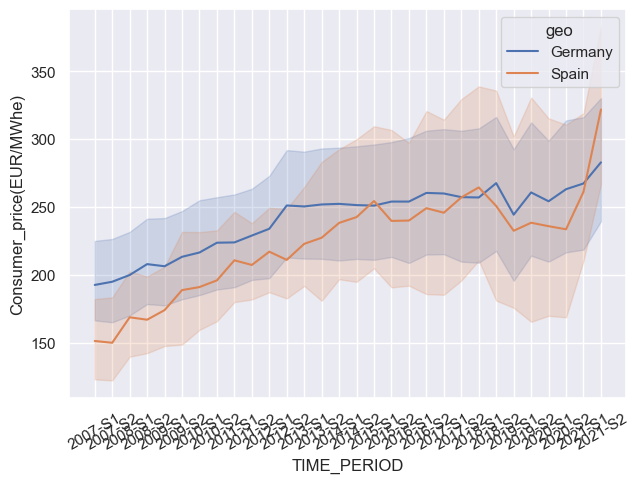

In [145]:

sns.set_theme(style="darkgrid")

fig = sns.lineplot(x="TIME_PERIOD", y="Consumer_price(EUR/MWhe)",
             hue="geo", 
             #style="consom",
             data=data_test_class3)
fig.xticks = fig.set_xticklabels(g.get_xticklabels(), rotation=30)

In [146]:
#next to look in to detail class 0 countries- Spain and Belgium, first looking at taxking affecting prices, then consumption 
#after that % price increases in varius components 

In [147]:
data_test_Spain = data_test.loc[data_test['geo'].isin(['Spain'])]

In [148]:
data_test_Germany = data_test.loc[data_test['geo'].isin(['Germany'])]

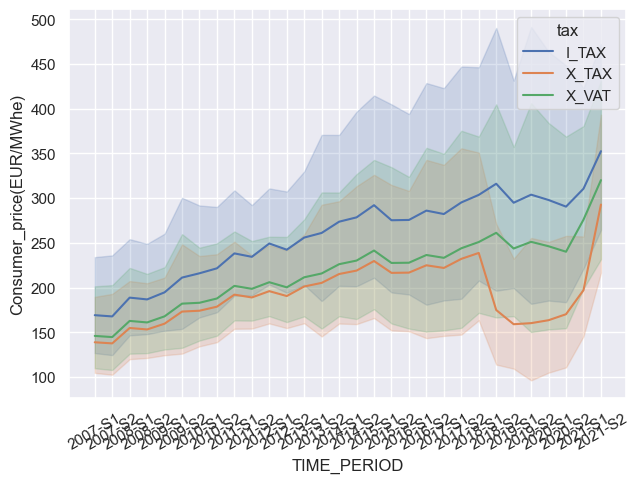

In [149]:

sns.set_theme(style="darkgrid")

fig = sns.lineplot(x="TIME_PERIOD", y="Consumer_price(EUR/MWhe)",
             hue="tax", 
             #style="consom",
             data=data_test_Spain)
fig.xticks = fig.set_xticklabels(g.get_xticklabels(), rotation=30)

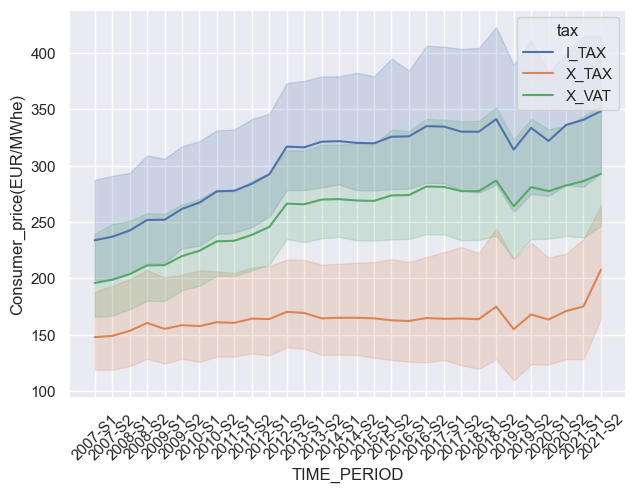

In [150]:
sns.set_theme(style="darkgrid")

fig = sns.lineplot(x="TIME_PERIOD", y="Consumer_price(EUR/MWhe)",
             hue="tax", 
             #style="consom",
             data=data_test_Germany)
fig.xticks = fig.set_xticklabels(g.get_xticklabels(), rotation=45)

In [151]:
data_test_SpainITAX = data_test_Spain.loc[data_test_Spain['tax'].isin(['I_TAX'])]

In [152]:
data_test_SpainXTAX = data_test_Spain.loc[data_test_Spain['tax'].isin(['X_TAX'])]

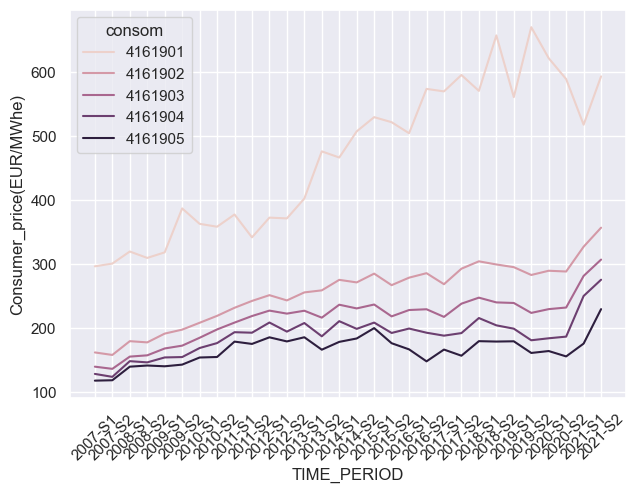

In [153]:

sns.set_theme(style="darkgrid")

fig = sns.lineplot(x="TIME_PERIOD", y="Consumer_price(EUR/MWhe)",
             hue="consom", 
             #style="consom",
             data=data_test_SpainITAX)
fig.xticks = fig.set_xticklabels(g.get_xticklabels(), rotation=45)

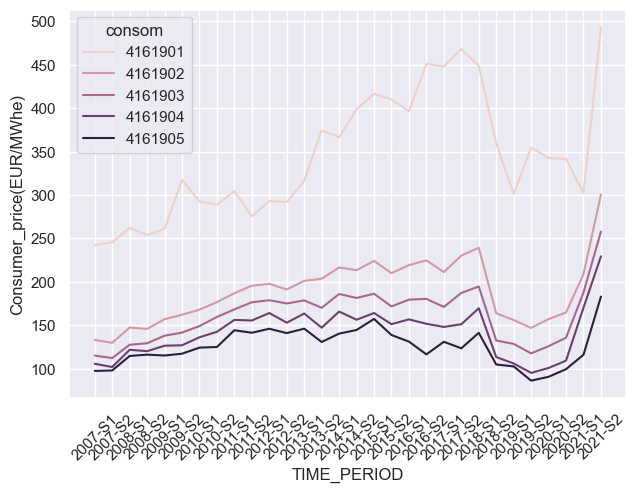

In [154]:

sns.set_theme(style="darkgrid")

fig = sns.lineplot(x="TIME_PERIOD", y="Consumer_price(EUR/MWhe)",
             hue="consom", 
             #style="consom",
             data=data_test_SpainXTAX)
fig.xticks = fig.set_xticklabels(g.get_xticklabels(), rotation=45)


    DA: customers consuming less than 1000 kWh.
    DB: customers consuming 1000 kWh or more but less than 2500 kWh.
    DC: customers consuming 2500 kWh or more but less than 5000 kWh.
    DD: customers consuming 5000 kWh or more but less than 15000 kWh.
    DE: customers consuming 15000 kWh or more.


In [155]:
data_test_GermanyITAX = data_test_Germany.loc[data_test_Germany['tax'].isin(['I_TAX'])]

In [156]:
data_test_GermanyXATX = data_test_Germany.loc[data_test_Germany['tax'].isin(['X_TAX'])]

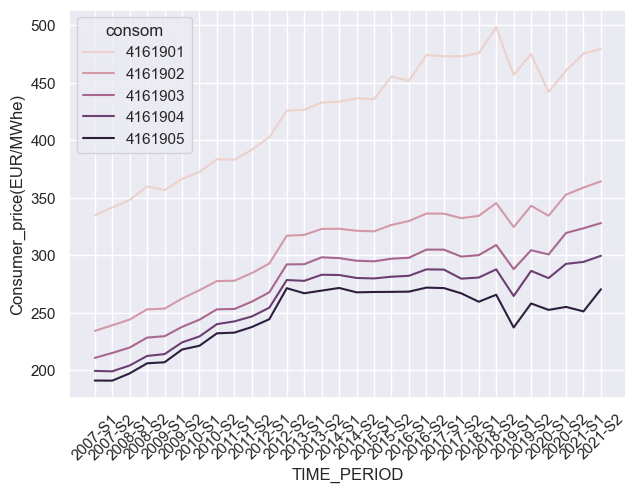

In [157]:

sns.set_theme(style="darkgrid")

fig = sns.lineplot(x="TIME_PERIOD", y="Consumer_price(EUR/MWhe)",
             hue="consom", 
             #style="consom",
             data=data_test_GermanyITAX)
fig.xticks = fig.set_xticklabels(g.get_xticklabels(), rotation=45)

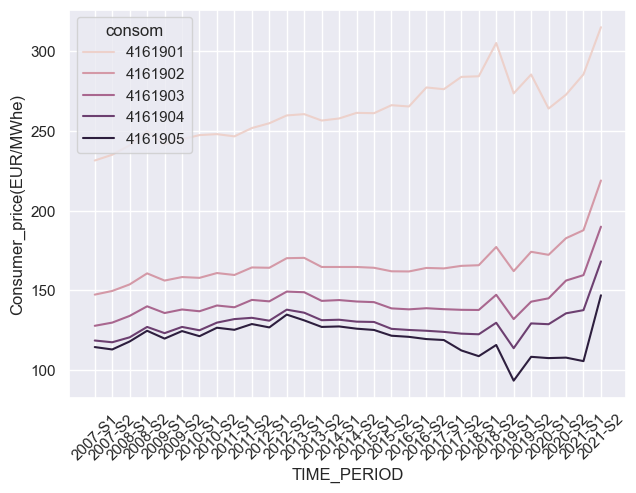

In [158]:

sns.set_theme(style="darkgrid")

fig = sns.lineplot(x="TIME_PERIOD", y="Consumer_price(EUR/MWhe)",
             hue="consom", 
             #style="consom",
             data=data_test_GermanyXATX)
fig.xticks = fig.set_xticklabels(g.get_xticklabels(), rotation=45)

In [159]:
data_test_SpainITAX_1 = data_test_SpainITAX.loc[data_test_SpainITAX['consom'].isin([4161902])]

In [160]:
data_test_SpainXTAX_1 = data_test_SpainXTAX.loc[data_test_SpainXTAX['consom'].isin([4161902])]

In [161]:
#% change on consumer price
data_test_SpainITAX_1['growth_YonY'] = data_test_SpainITAX_1['Consumer_price(EUR/MWhe)'].pct_change()

<AxesSubplot:>

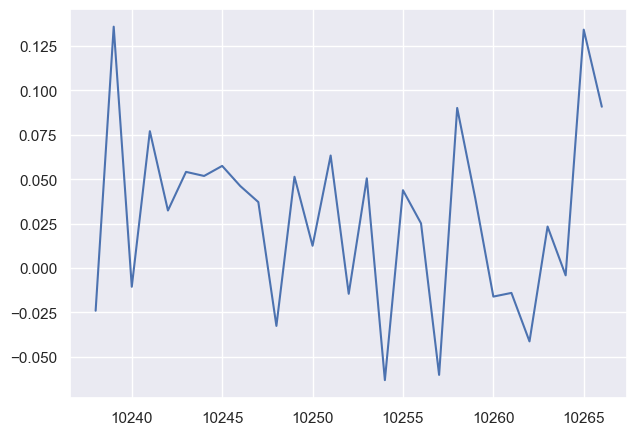

In [162]:
data_test_SpainITAX_1['Consumer_price(EUR/MWhe)'].pct_change().plot()

In [163]:
data_test_SpainITAX_1['growth'] = data_test_SpainITAX_1.groupby('geo')['Consumer_price(EUR/MWhe)'].apply(lambda x: x.div(x.iloc[0]).subtract(1).mul(100))

In [164]:
data_test_SpainITAX_1.head(1)

consom unit    tax currency    geo TIME_PERIOD  \
10237  4161902  KWH  I_TAX      EUR  Spain     2007-S2   

       Consumer_price(EUR/MWhe) period     A   B  Period  growth_YonY  growth  
10237                     162.2      2  2007  S2  2007.2          NaN     0.0

In [165]:
data_test_Estonia = data_test.loc[data_test['geo'].isin(['Estonia'])]
data_test_EstoniaITAX = data_test_Estonia.loc[data_test_Estonia['tax'].isin(['I_TAX'])]

In [166]:
data_test_EstoniaITAX_1 = data_test_EstoniaITAX.loc[data_test_EstoniaITAX['consom'].isin([4161902])]
data_test_EstoniaITAX_1['growth_YonY'] = data_test_EstoniaITAX_1['Consumer_price(EUR/MWhe)'].pct_change()


In [167]:
data_test_EstoniaITAX_1['growth'] = data_test_EstoniaITAX_1.groupby('geo')['Consumer_price(EUR/MWhe)'].apply(lambda x: x.div(x.iloc[0]).subtract(1).mul(100))

In [168]:
data_test_Bulgaria = data_test.loc[data_test['geo'].isin(['Bulgaria'])]
data_test_BulgariaITAX = data_test_Bulgaria.loc[data_test_Bulgaria['tax'].isin(['I_TAX'])]
data_test_BulgariaITAX_1 = data_test_BulgariaITAX.loc[data_test_BulgariaITAX['consom'].isin([4161902])]
data_test_BulgariaITAX_1['growth_YonY'] = data_test_BulgariaITAX_1['Consumer_price(EUR/MWhe)'].pct_change()

In [169]:
data_test_BulgariaITAX_1['growth'] = data_test_BulgariaITAX_1.groupby('geo')['Consumer_price(EUR/MWhe)'].apply(lambda x: x.div(x.iloc[0]).subtract(1).mul(100))

In [170]:
data_test_Sweden = data_test.loc[data_test['geo'].isin(['Sweden'])]

In [171]:
data_test_SwedenITAX = data_test_Sweden.loc[data_test_Sweden['tax'].isin(['I_TAX'])]

In [172]:
data_test_SwedenITAX_1 = data_test_SwedenITAX.loc[data_test_SwedenITAX['consom'].isin([4161902])]

In [173]:
data_test_SwedenITAX_1['growth_YonY'] = data_test_SwedenITAX_1['Consumer_price(EUR/MWhe)'].pct_change()

In [174]:
data_test_SwedenITAX_1['growth'] = data_test_SwedenITAX_1.groupby('geo')['Consumer_price(EUR/MWhe)'].apply(lambda x: x.div(x.iloc[0]).subtract(1).mul(100))

In [175]:
data_test_SwedenITAX_1.head(5)

consom unit    tax currency     geo TIME_PERIOD  \
10875  4161902  KWH  I_TAX      EUR  Sweden     2007-S2   
10876  4161902  KWH  I_TAX      EUR  Sweden     2008-S1   
10877  4161902  KWH  I_TAX      EUR  Sweden     2008-S2   
10878  4161902  KWH  I_TAX      EUR  Sweden     2009-S1   
10879  4161902  KWH  I_TAX      EUR  Sweden     2009-S2   

       Consumer_price(EUR/MWhe) period     A   B  Period  growth_YonY  \
10875                     173.4      2  2007  S2  2007.2          NaN   
10876                     187.4      1  2008  S1  2008.1     0.080738   
10877                     194.9      2  2008  S2  2008.2     0.040021   
10878                     179.5      1  2009  S1  2009.1    -0.079015   
10879                     181.9      2  2009  S2  2009.2     0.013370   

          growth  
10875   0.000000  
10876   8.073818  
10877  12.399077  
10878   3.517878  
10879   4.901961

In [176]:
data['Datetime (UTC)'].value_counts()

2018-12-01 12:00:00    28
2019-11-21 13:00:00    28
2019-11-21 00:00:00    28
2019-11-21 01:00:00    28
2019-11-21 02:00:00    28
                       ..
2016-01-01 02:00:00    25
2016-01-01 03:00:00    25
2016-01-01 04:00:00    25
2016-01-01 05:00:00    25
2015-01-01 00:00:00    25
Name: Datetime (UTC), Length: 68664, dtype: int64

In [177]:
data["Datetime (UTC)"] = pd.to_datetime(data["Datetime (UTC)"])


In [178]:
data.head()

Country ISO3 Code      Datetime (UTC)     Datetime (Local)  \
0  Austria       AUT 2015-01-01 00:00:00  2015-01-01 01:00:00   
1  Austria       AUT 2015-01-01 01:00:00  2015-01-01 02:00:00   
2  Austria       AUT 2015-01-01 02:00:00  2015-01-01 03:00:00   
3  Austria       AUT 2015-01-01 03:00:00  2015-01-01 04:00:00   
4  Austria       AUT 2015-01-01 04:00:00  2015-01-01 05:00:00   

   Price (EUR/MWhe)  
0             17.93  
1             15.17  
2             16.38  
3             17.38  
4             16.38

In [179]:
df = data[(data['Datetime (UTC)'] > '2021-2-1') & (data['Datetime (UTC)'] <= '2021-2-28')]



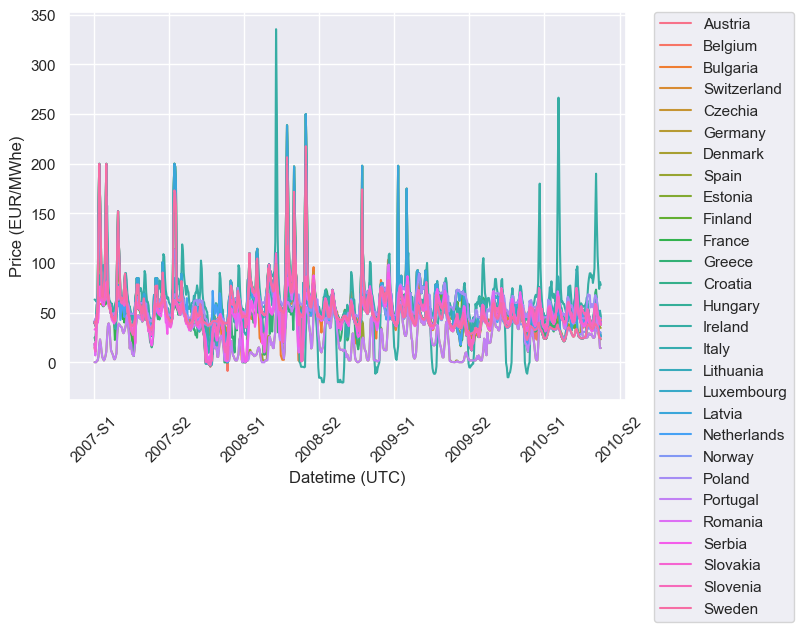

In [180]:
sns.set_theme(style="darkgrid")

fig = sns.lineplot(x = "Datetime (UTC)", y = "Price (EUR/MWhe)", data=df, hue="Country")

fig.xticks = fig.set_xticklabels(g.get_xticklabels(), rotation=45)
fig.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)


In [181]:
df.sort_values(['Price (EUR/MWhe)'],axis=0, ascending=True)

Country ISO3 Code      Datetime (UTC)     Datetime (Local)  \
975534     Ireland       IRL 2021-02-14 06:00:00  2021-02-14 06:00:00   
975510     Ireland       IRL 2021-02-13 06:00:00  2021-02-13 06:00:00   
975535     Ireland       IRL 2021-02-14 07:00:00  2021-02-14 07:00:00   
975533     Ireland       IRL 2021-02-14 05:00:00  2021-02-14 05:00:00   
975532     Ireland       IRL 2021-02-14 04:00:00  2021-02-14 04:00:00   
...            ...       ...                 ...                  ...   
656263     Finland       FIN 2021-02-12 07:00:00  2021-02-12 09:00:00   
1108423  Lithuania       LTU 2021-02-12 07:00:00  2021-02-12 09:00:00   
975450     Ireland       IRL 2021-02-10 18:00:00  2021-02-10 18:00:00   
975810     Ireland       IRL 2021-02-25 18:00:00  2021-02-25 18:00:00   
975449     Ireland       IRL 2021-02-10 17:00:00  2021-02-10 17:00:00   

         Price (EUR/MWhe)  
975534             -20.43  
975510             -20.12  
975535             -20.04  
975533             -20.04  
975532             -20.00  
...                   ...  
656263             249.98  
1108423            249.98  
975450             251.25  
975810             266.56  
975449             335.52  

[18144 rows x 5 columns]

In [182]:
Bulgaria

consom unit    tax currency       geo TIME_PERIOD  \
103    4161901  KWH  I_TAX      EUR  Bulgaria     2007-S2   
104    4161901  KWH  I_TAX      EUR  Bulgaria     2008-S1   
105    4161901  KWH  I_TAX      EUR  Bulgaria     2008-S2   
106    4161901  KWH  I_TAX      EUR  Bulgaria     2009-S1   
107    4161901  KWH  I_TAX      EUR  Bulgaria     2009-S2   
...        ...  ...    ...      ...       ...         ...   
46772  4161905  KWH  X_VAT      EUR  Bulgaria     2020-S1   
46773  4161905  KWH  X_VAT      EUR  Bulgaria     2020-S2   
46774  4161905  KWH  X_VAT      EUR  Bulgaria     2021-S1   
46775  4161905  KWH  X_VAT      EUR  Bulgaria     2021-S2   
46776  4161905  KWH  X_VAT      EUR  Bulgaria     2022-S1   

       Consumer_price(EUR/MWhe)  
103                        74.1  
104                        74.1  
105                        82.3  
106                        84.4  
107                        82.3  
...                         ...  
46772                      77.7  
46773                      79.1  
46774                      78.8  
46775                      89.9  
46776                      89.7  

[450 rows x 7 columns]

In [183]:
data_test_SpainITAX_1.head(1)

consom unit    tax currency    geo TIME_PERIOD  \
10237  4161902  KWH  I_TAX      EUR  Spain     2007-S2   

       Consumer_price(EUR/MWhe) period     A   B  Period  growth_YonY  growth  
10237                     162.2      2  2007  S2  2007.2          NaN     0.0

In [184]:
data_test_SwedenITAX_1['growth']

10875     0.000000
10876     8.073818
10877    12.399077
10878     3.517878
10879     4.901961
10880    14.878893
10881    22.202999
10882    31.603230
10883    28.316032
10884    27.681661
10885    30.565167
10886    33.679354
10887    28.546713
10888    25.951557
10889    24.682814
10890    20.415225
10891    20.415225
10892    24.625144
10893    26.585928
10894    27.623991
10895    29.815456
10896    30.392157
10897    36.562860
10898    37.716263
10899    37.946943
10900    21.972318
10901    17.531719
10902    37.773933
10903    65.743945
10904    60.668973
Name: growth, dtype: float64

In [185]:
data_test_EstoniaITAX_1['TIME_PERIOD']


colors_clusters = ['Coral', 'DarkCyan', 
                   'Gold','Lightgreen']

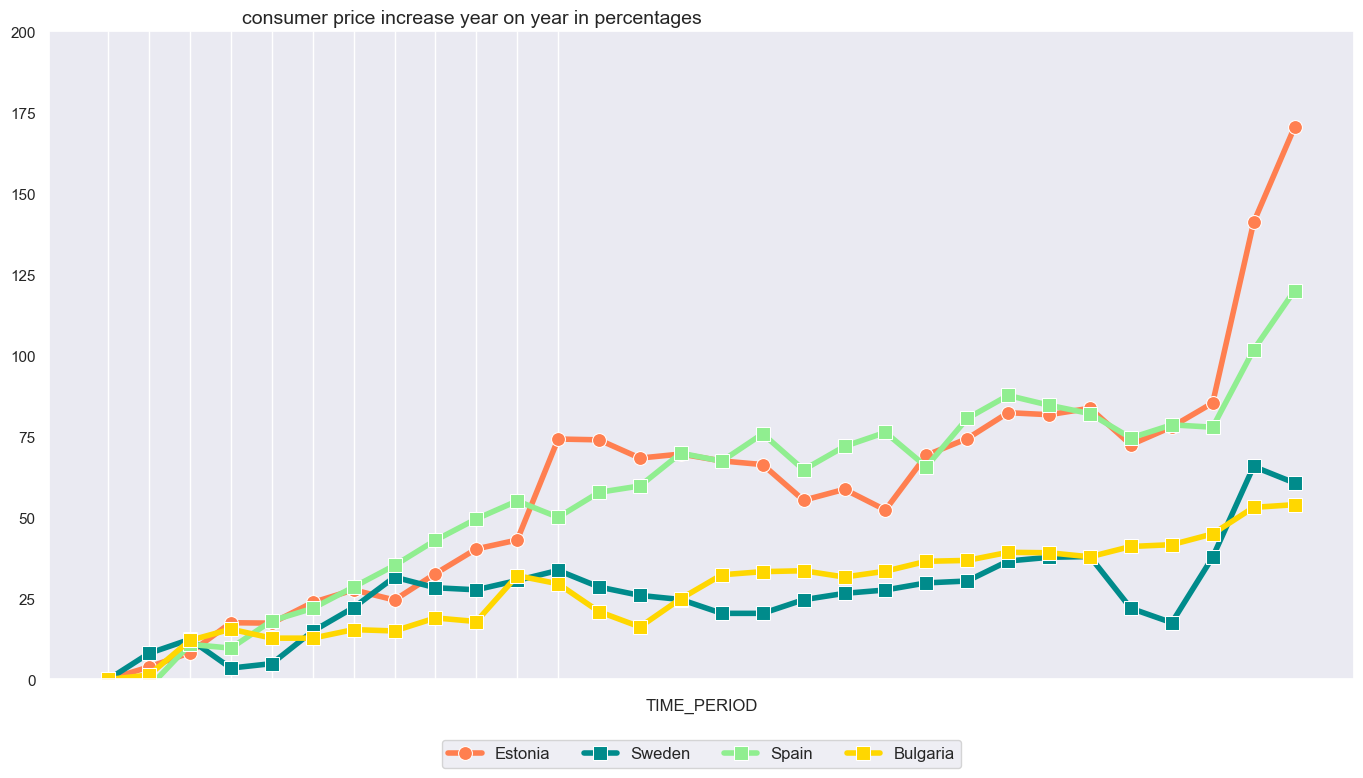

In [193]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
#sns.lineplot(x="Year", y="signal", hue="label", data=data_preproc)

sns.lineplot(x=data_test_EstoniaITAX_1['TIME_PERIOD'],y=data_test_EstoniaITAX_1['growth'],data=data_test_EstoniaITAX_1,marker='o',
             markersize=10,lw=4,label = 'Estonia',color='Coral',ax=ax)

sns.lineplot(x=data_test_SwedenITAX_1['TIME_PERIOD'],y=data_test_SwedenITAX_1['growth'],data=data_test_SwedenITAX_1,marker='s',
             markersize=10,lw=4,label = 'Sweden',color='DarkCyan',ax=ax)

sns.lineplot(x=data_test_SpainITAX_1['TIME_PERIOD'],y=data_test_SpainITAX_1['growth'],data=data_test_SpainITAX_1,marker='s',
             markersize=10,lw=4,label = 'Spain',color='Lightgreen',ax=ax)

sns.lineplot(x=data_test_BulgariaITAX_1['TIME_PERIOD'],y=data_test_BulgariaITAX_1['growth'],data=data_test_BulgariaITAX_1,marker='s',
             markersize=10,lw=4,label = 'Bulgaria',color='Gold',ax=ax)

plt.title(('consumer price increase year on year in percentages'),fontsize=14,ha='right')

# Put a legend below current axis
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=False, ncol=5,fontsize=12)
plt.grid(axis='y')
plt.ylabel('')
plt.ylim(0,200)
ax.tick_params(axis='x', rotation=70, labelsize = 8)

ax.set(xticks=range(0, 12), xticklabels = names.index.values.tolist());
            